In [56]:
# Import libraries
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import sweetviz as sv
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error,mean_absolute_percentage_error, mean_squared_error

# Surpress warnings 
import warnings
warnings.filterwarnings('ignore')

In [57]:
df = pd.read_csv(
    Path('Data/kc_house_data.csv'),
    index_col='date',
    infer_datetime_format=True,
    parse_dates=True
)

df.shape

(21613, 20)

#### Generating report for features

                                             |          | [  0%]   00:00 -> (? left)

Report Reports/exploratory_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



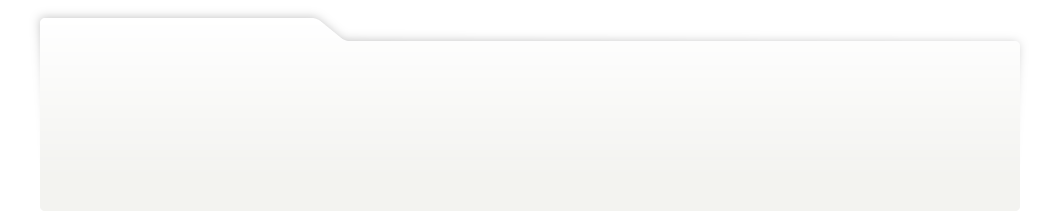
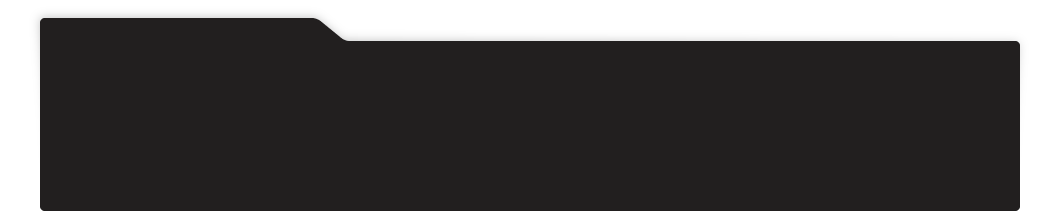
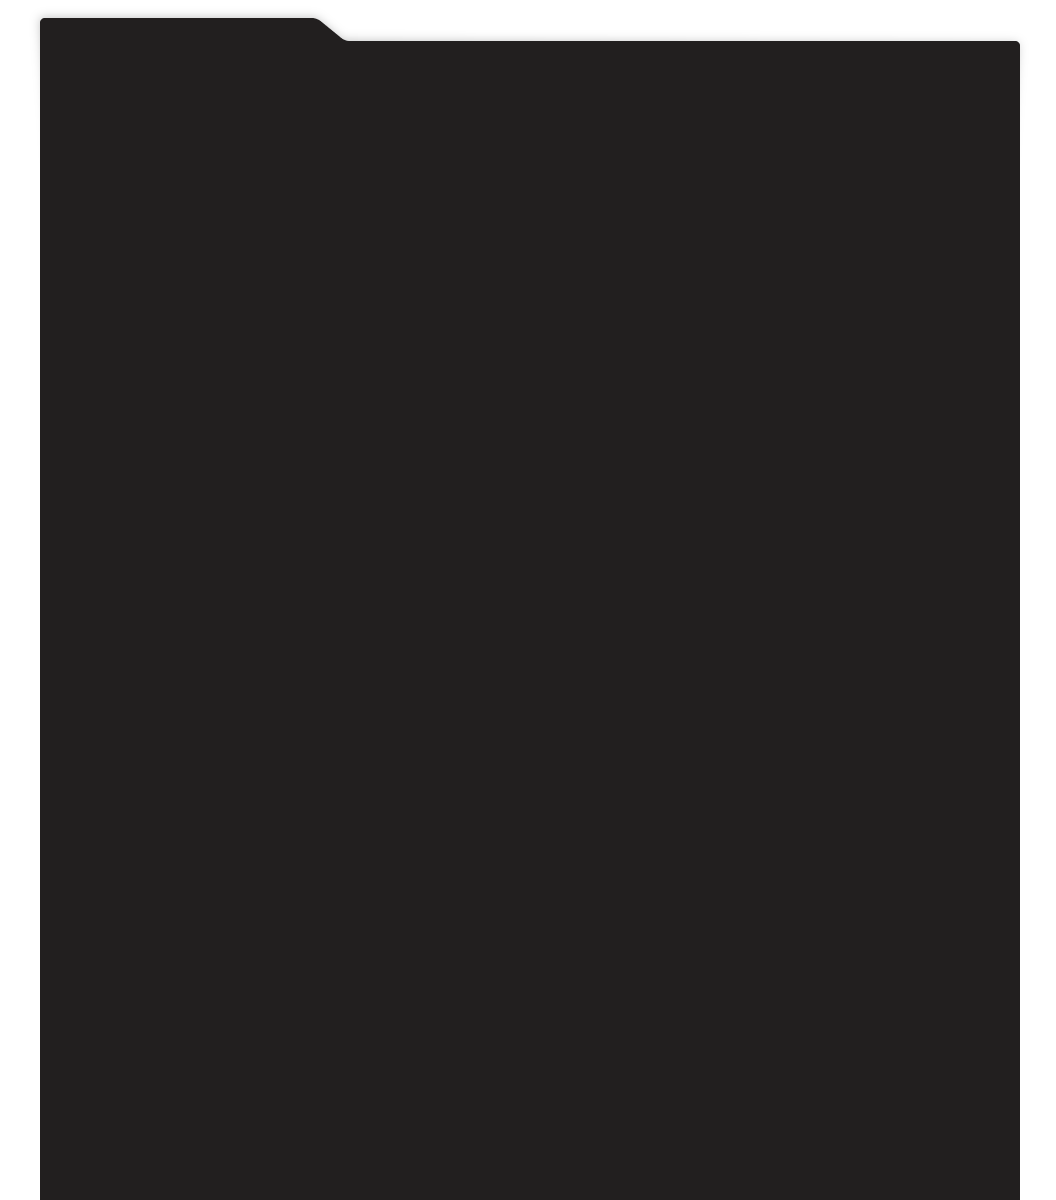
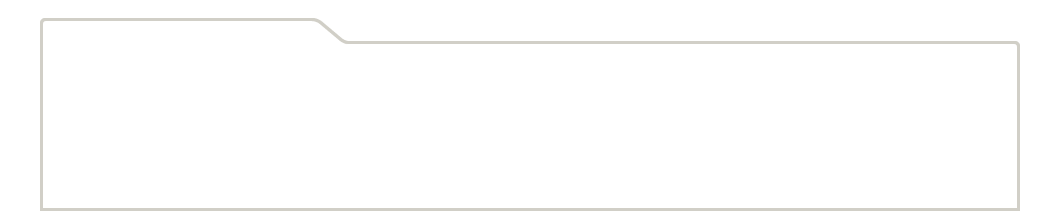
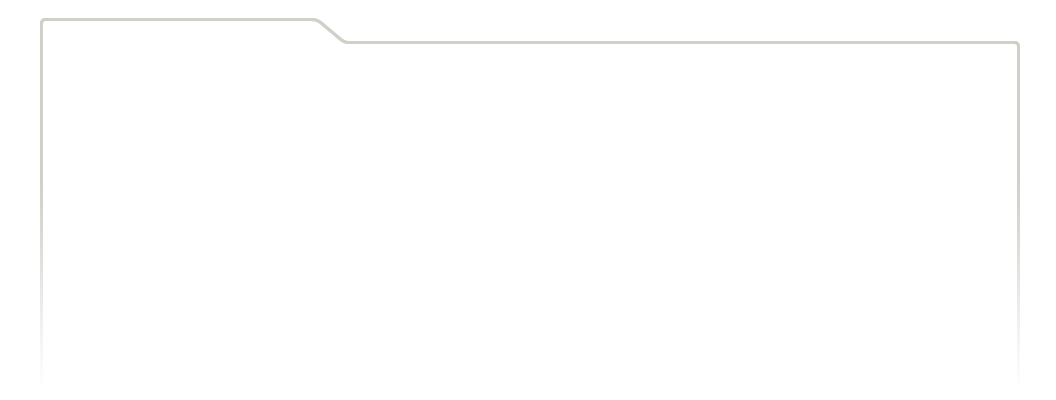
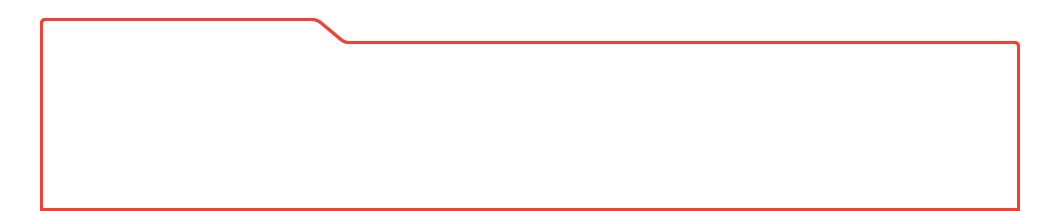
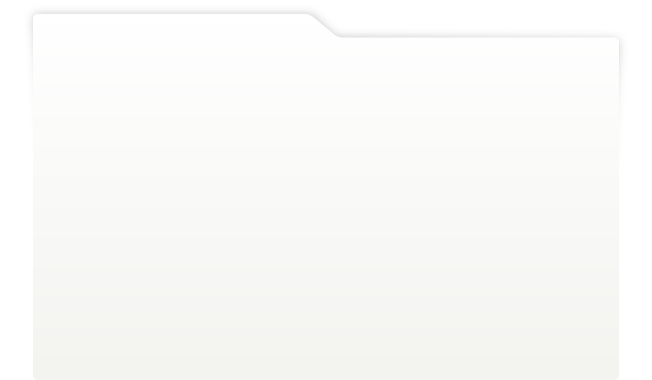
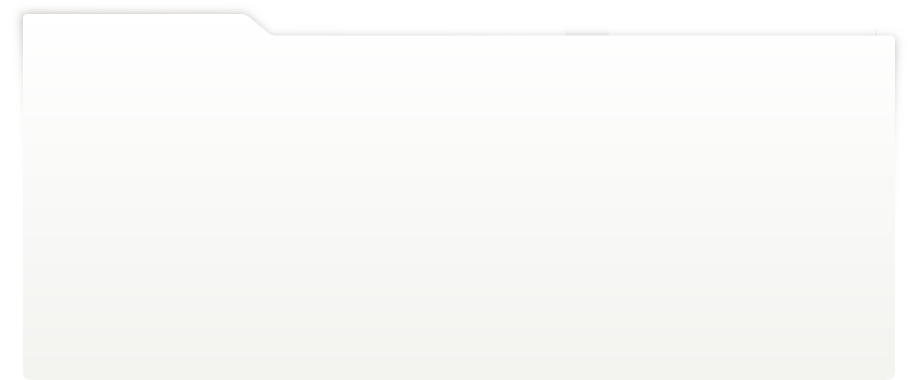
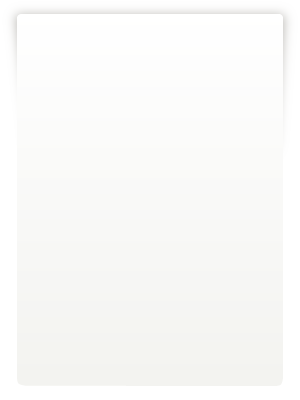
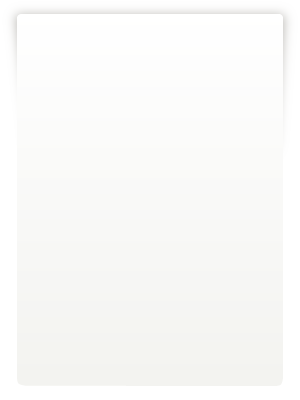
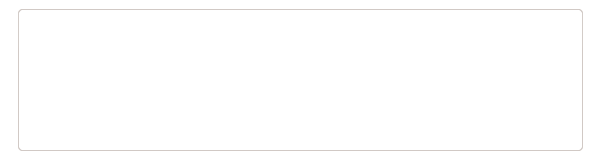
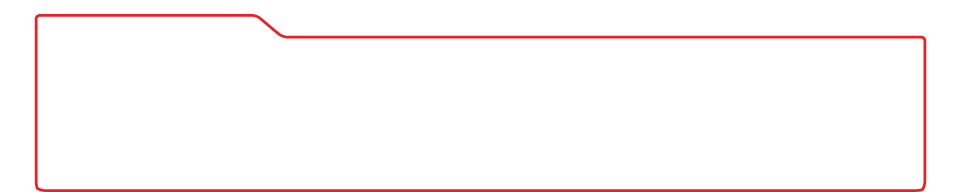
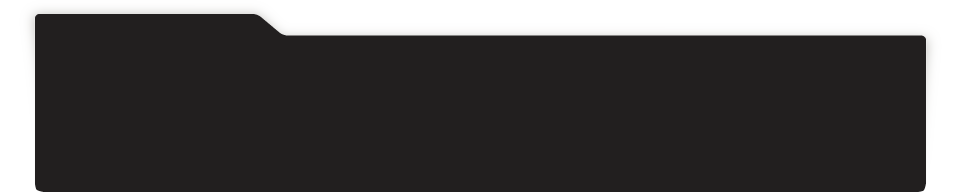
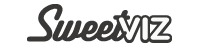
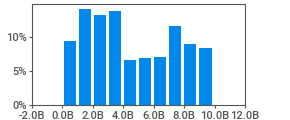
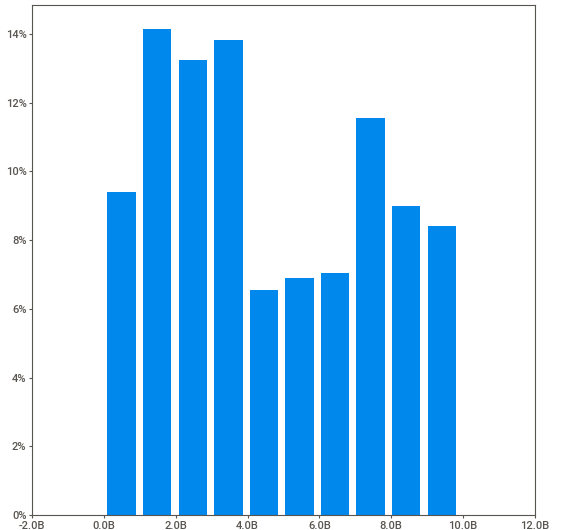
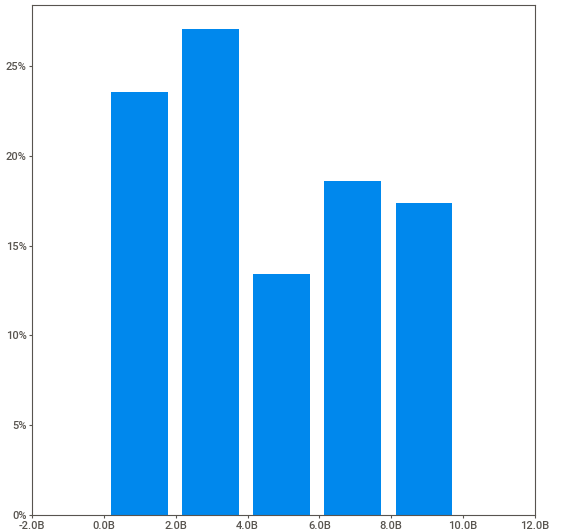
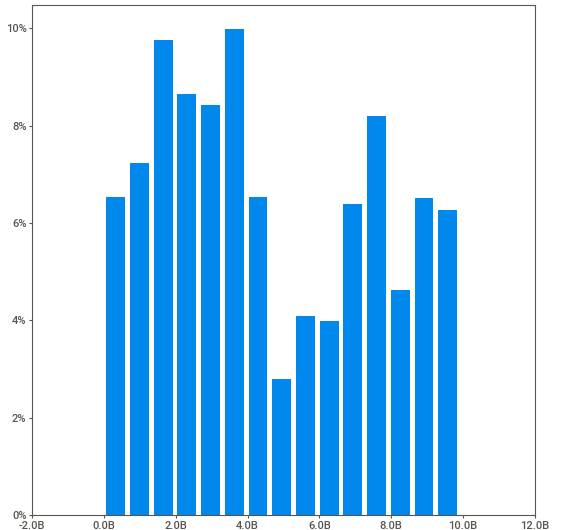
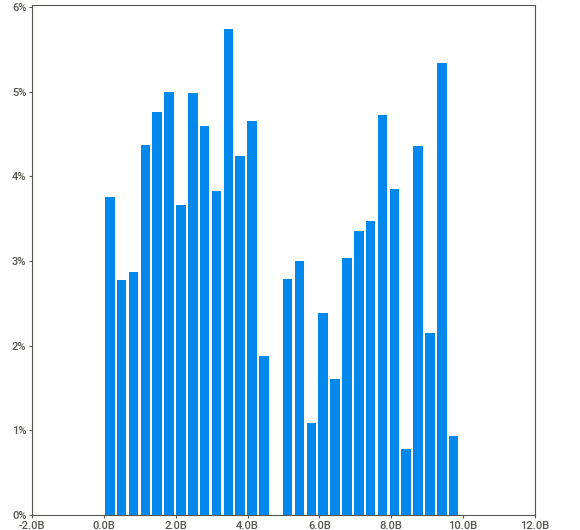
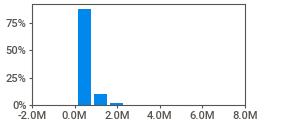
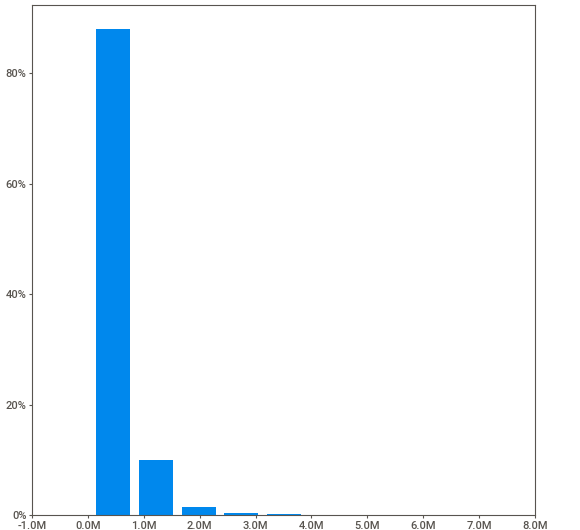
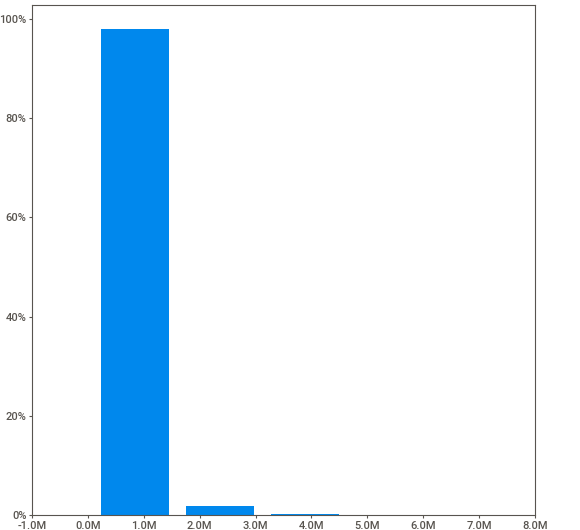
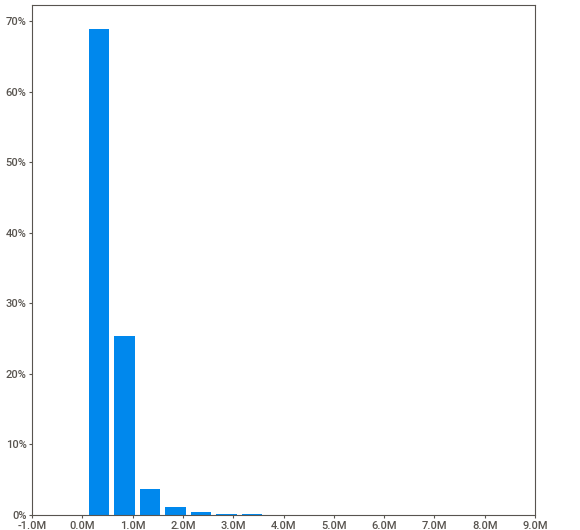
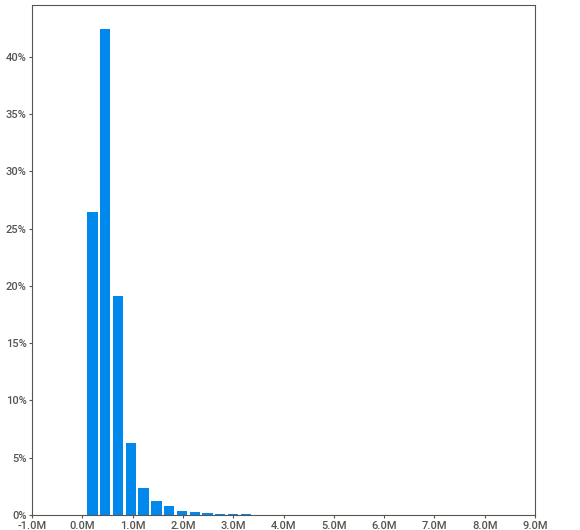
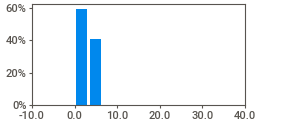
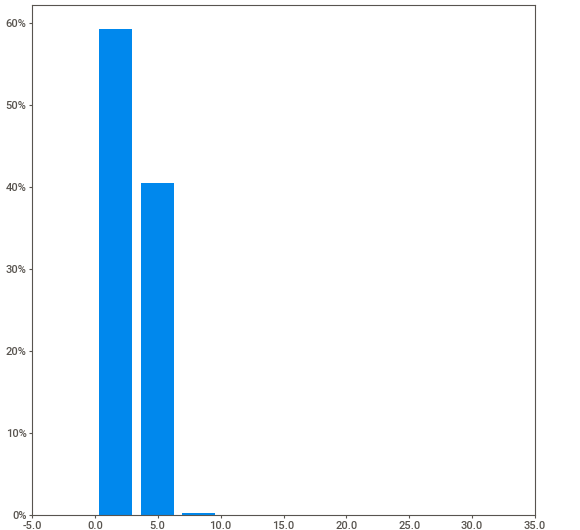
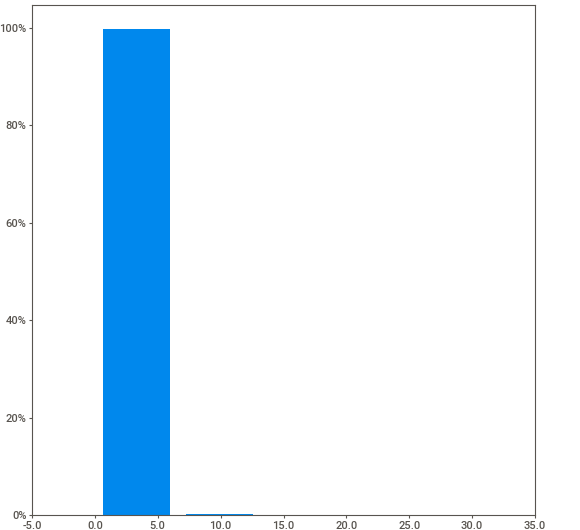
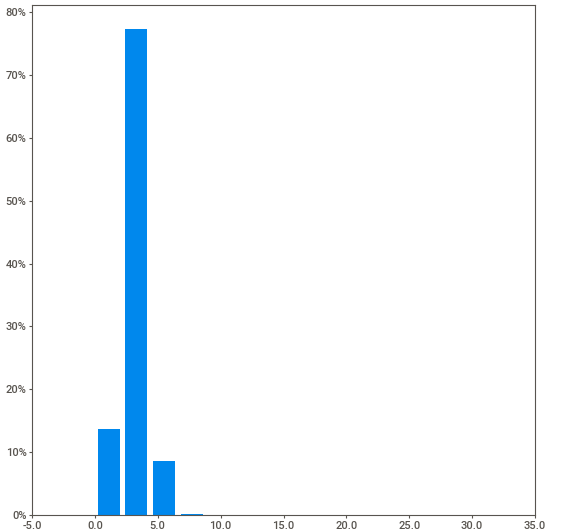
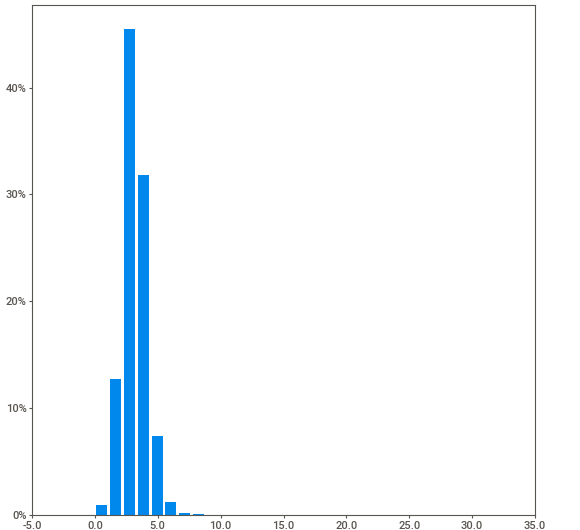
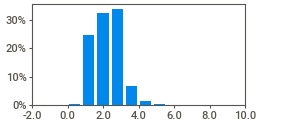
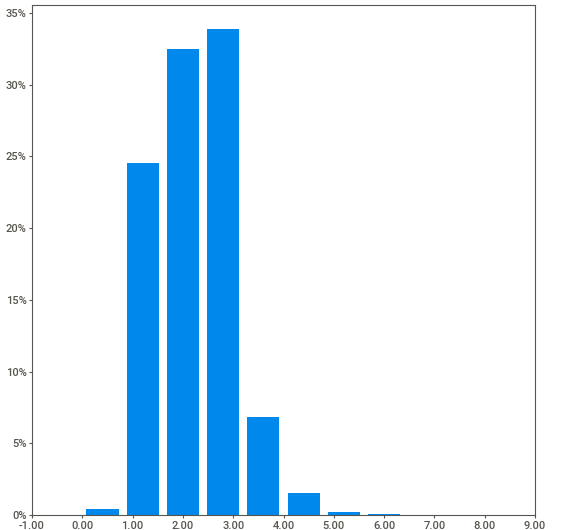
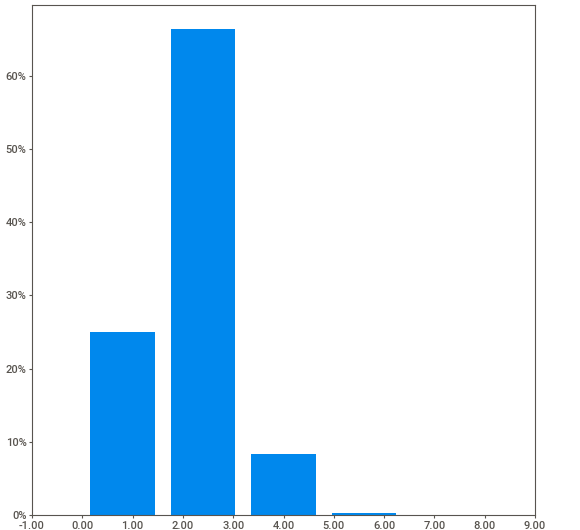
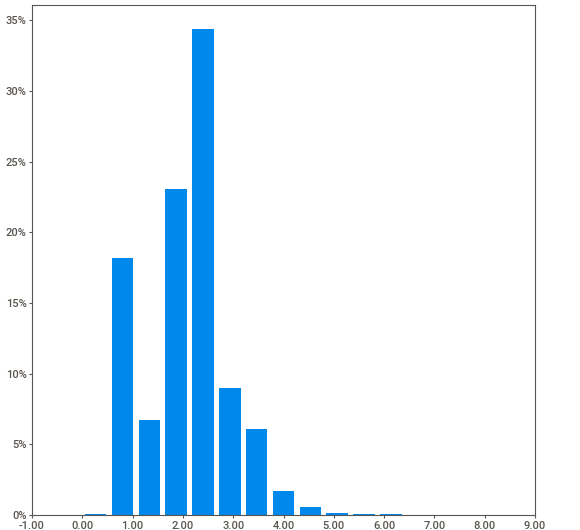
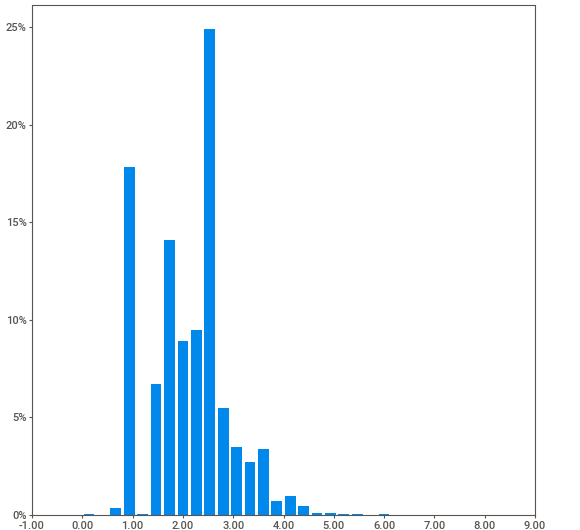
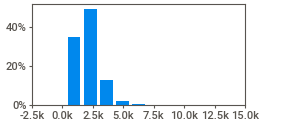
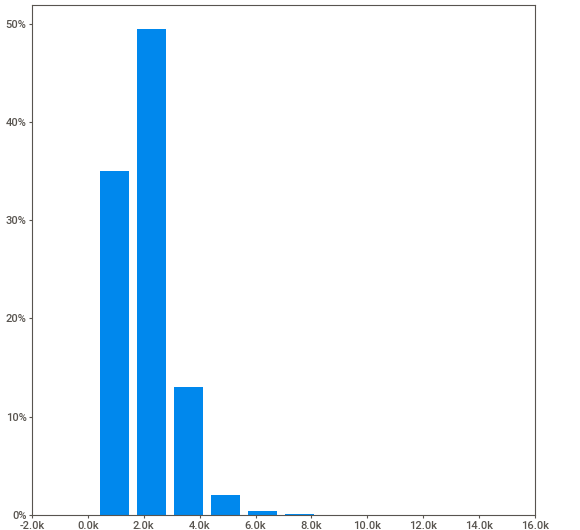
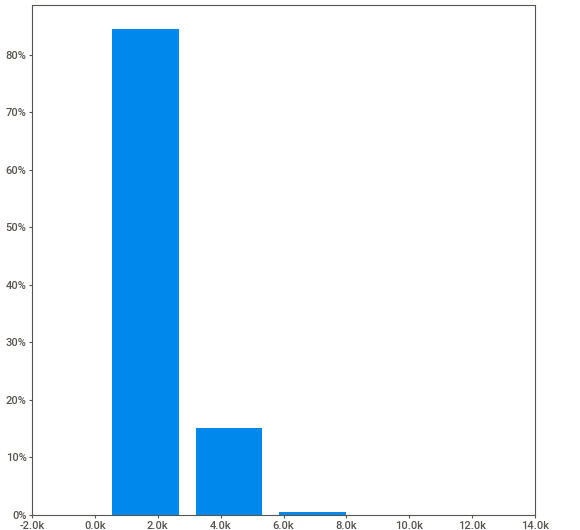
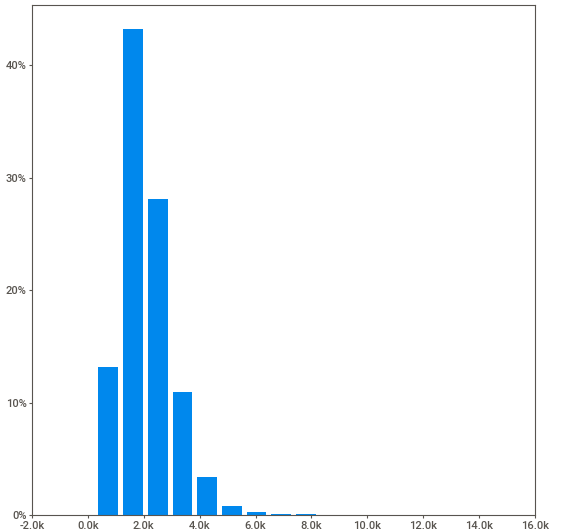
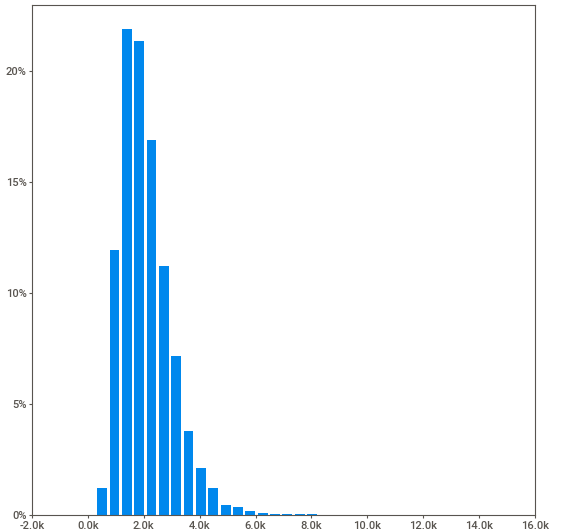
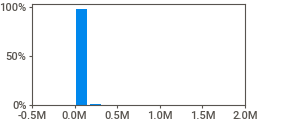
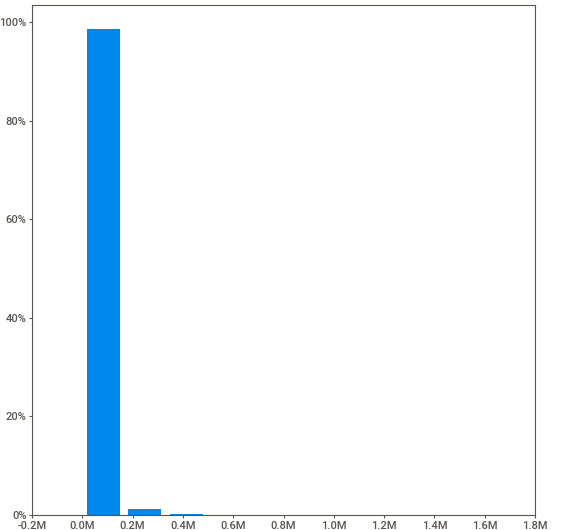
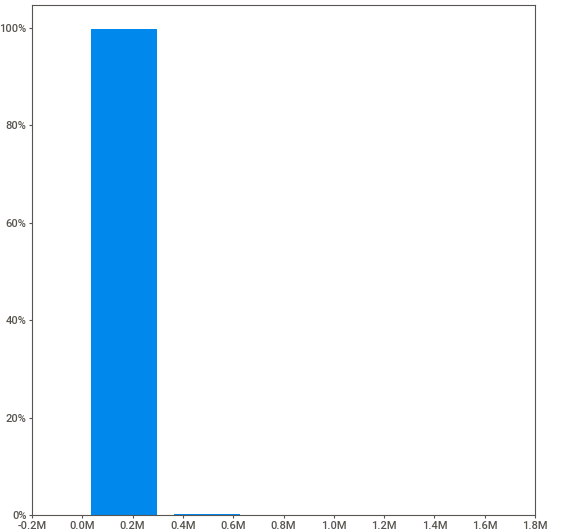
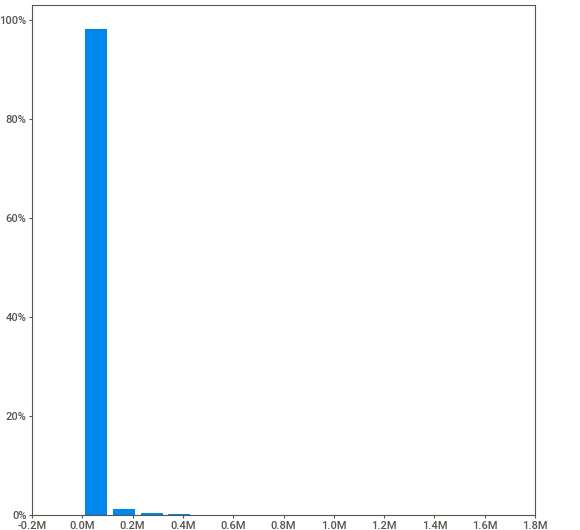
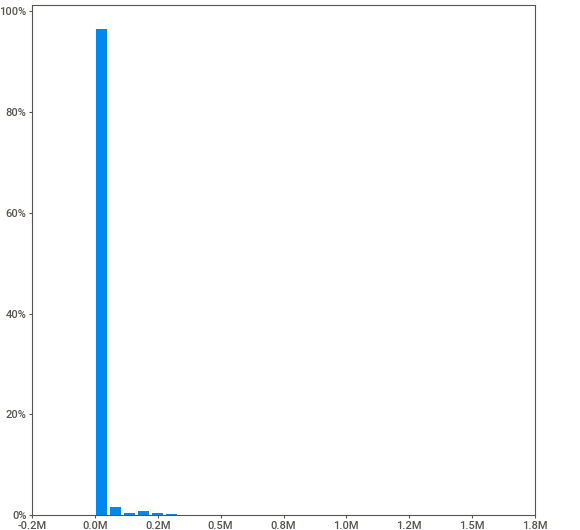
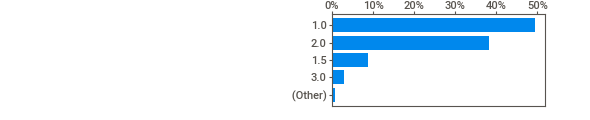
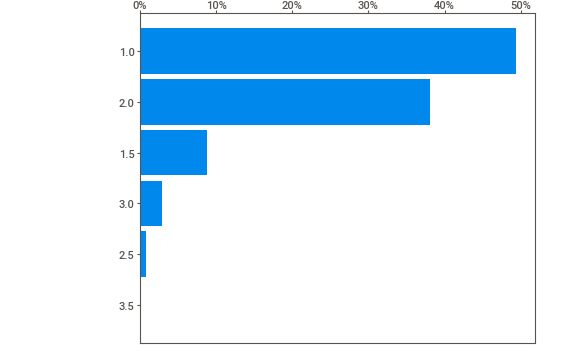
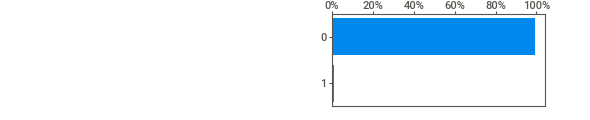
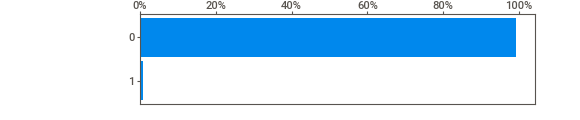
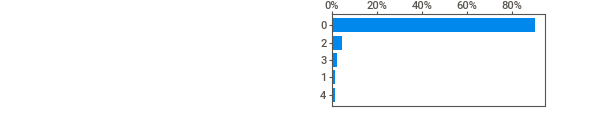
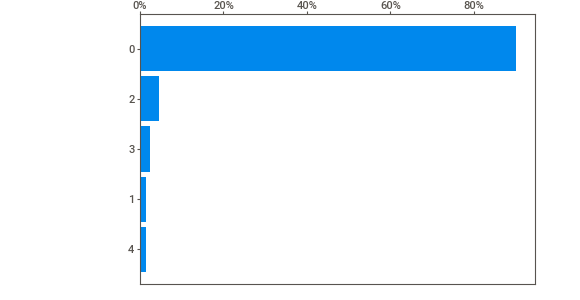
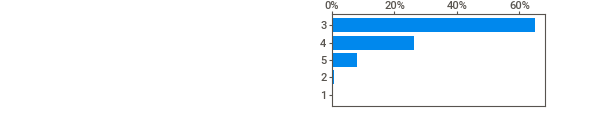
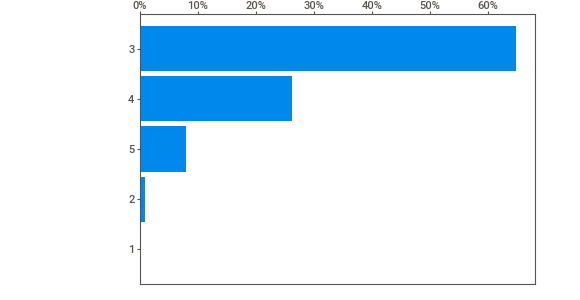
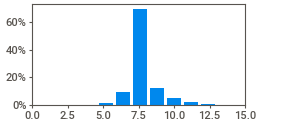
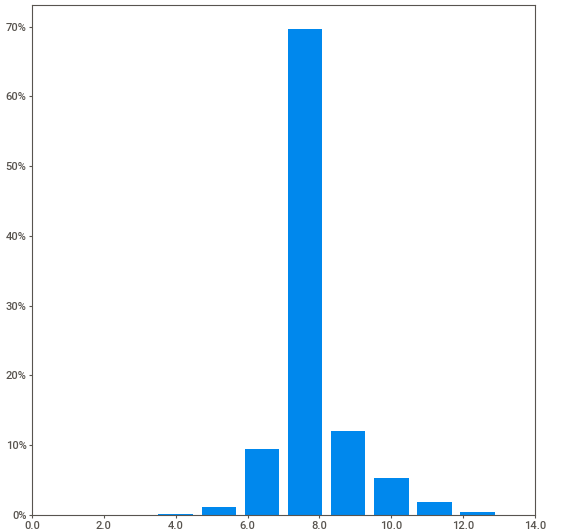
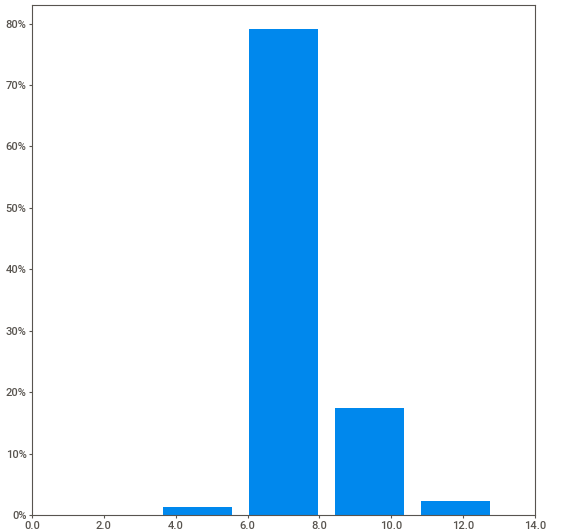
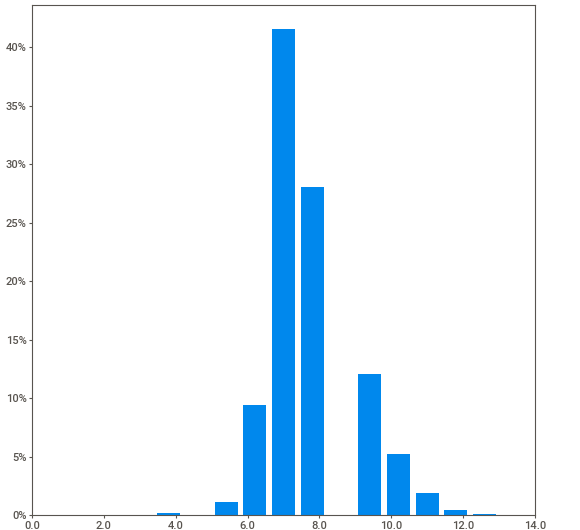
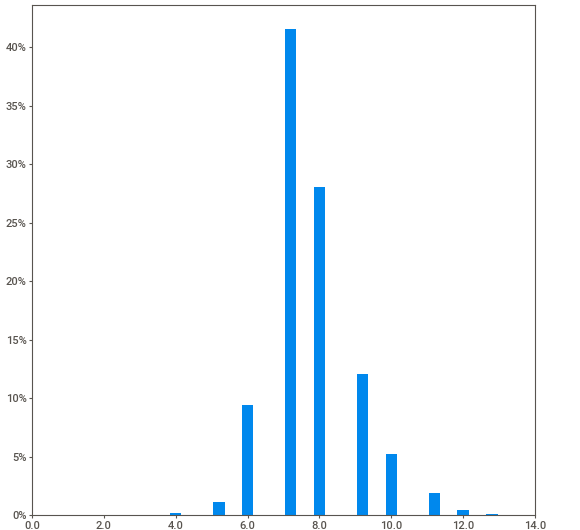
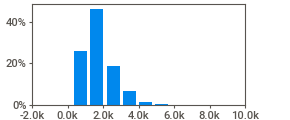
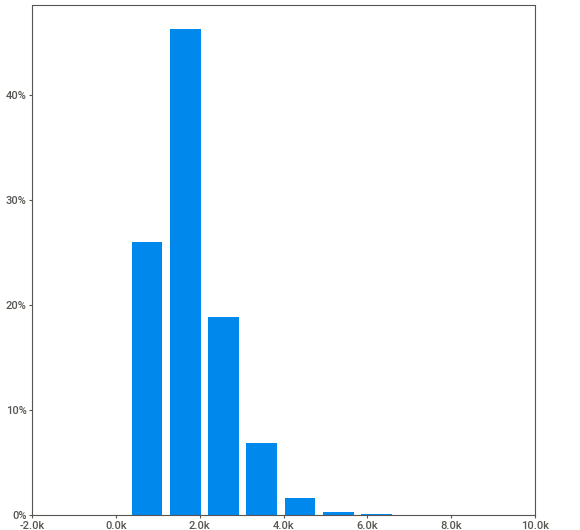
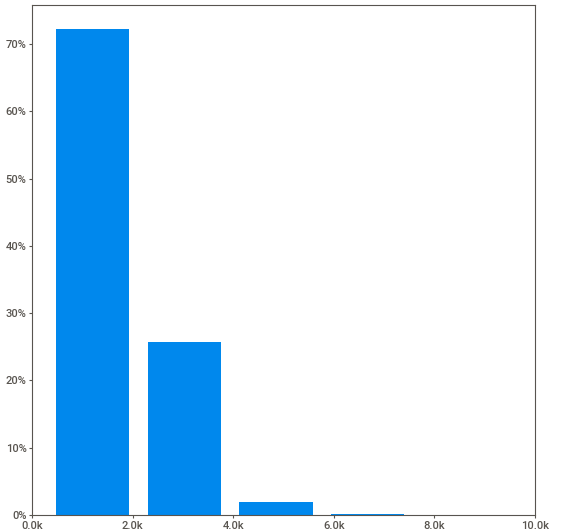
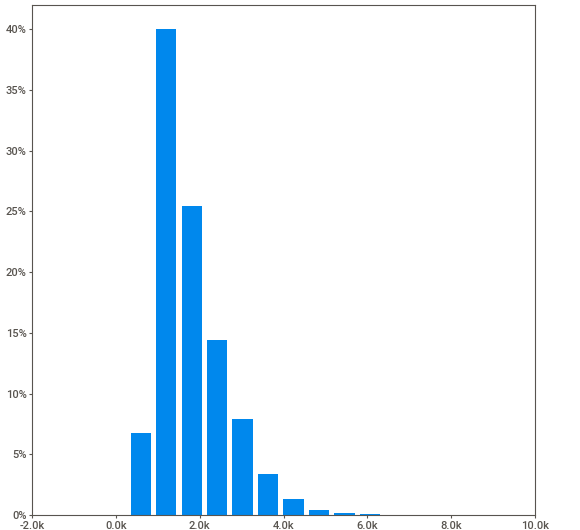
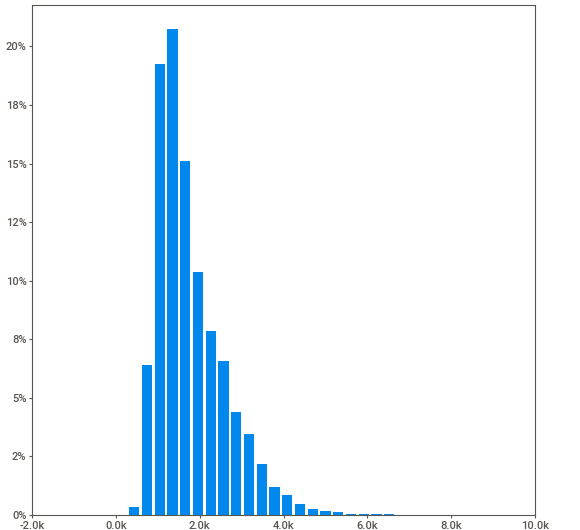
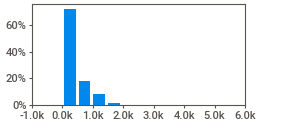
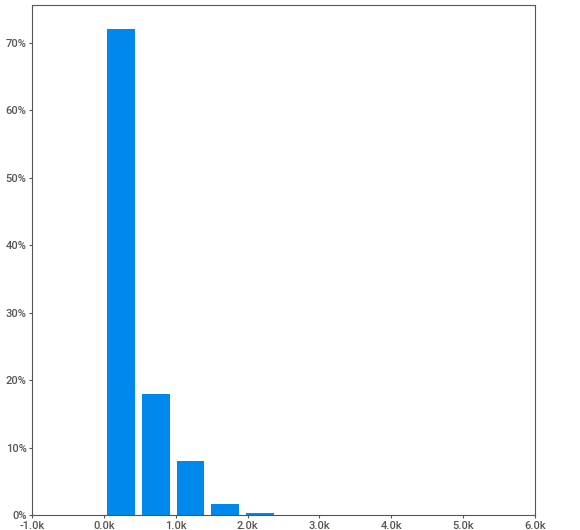
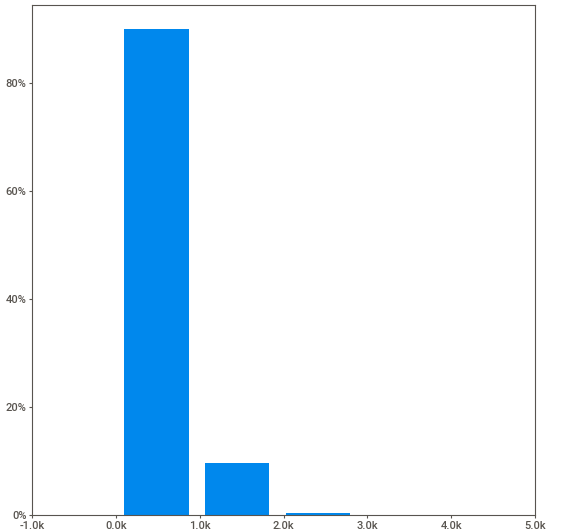
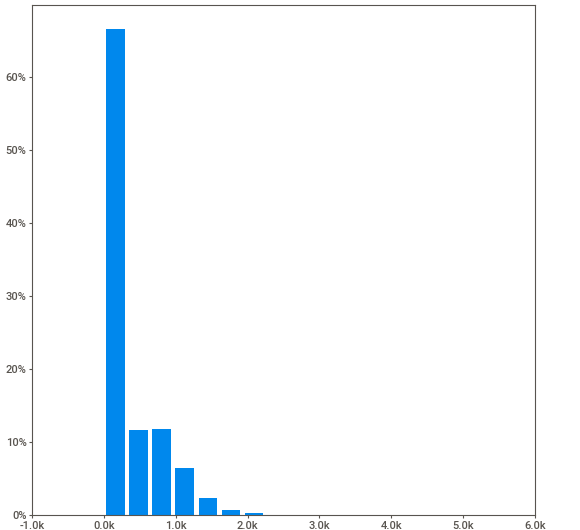
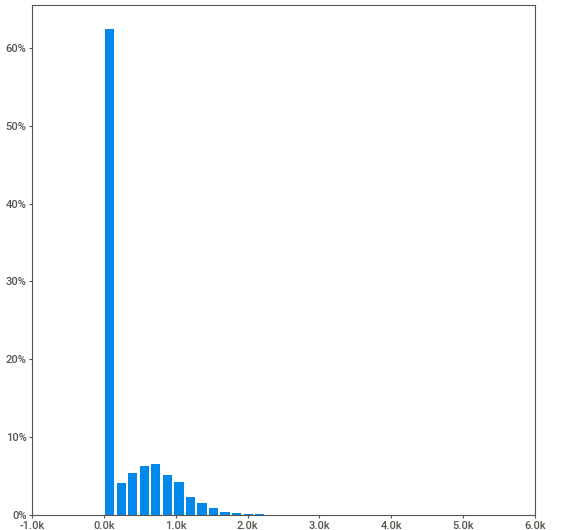
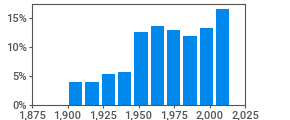
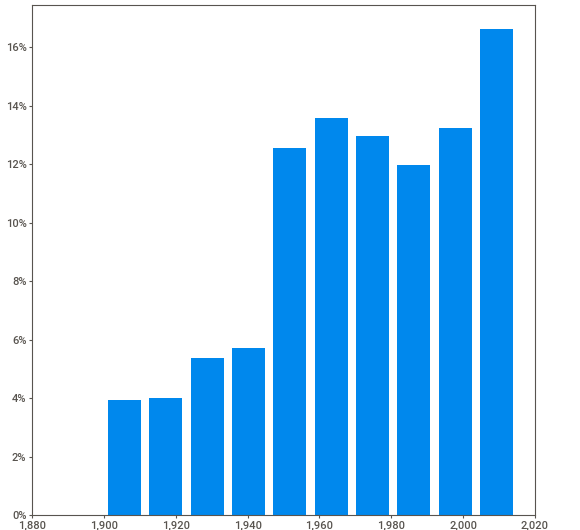
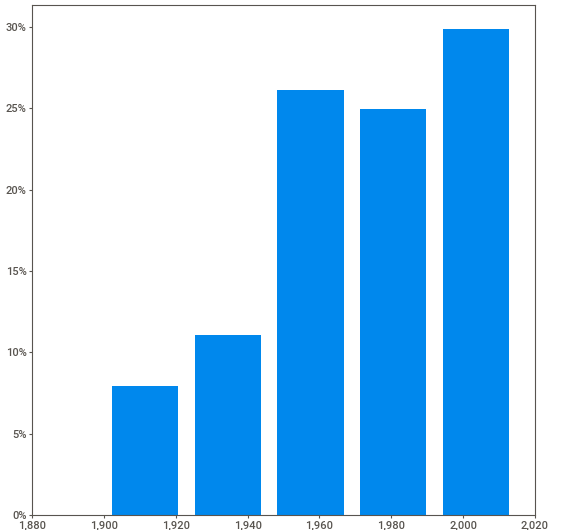
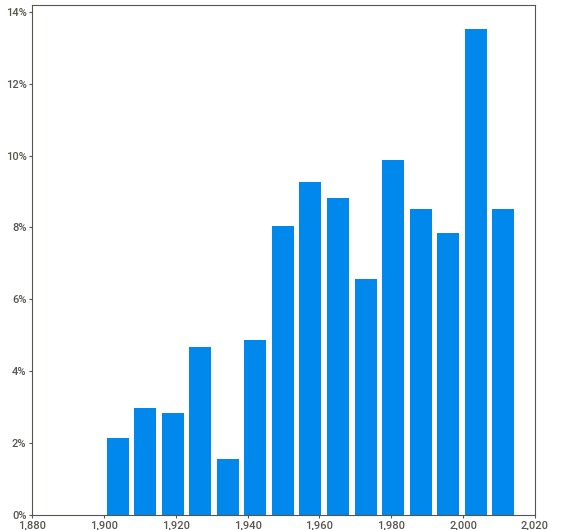
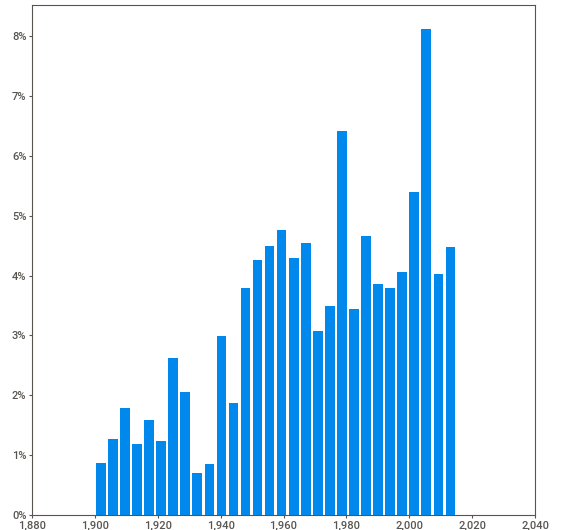
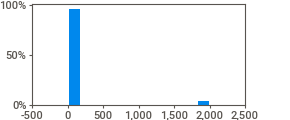
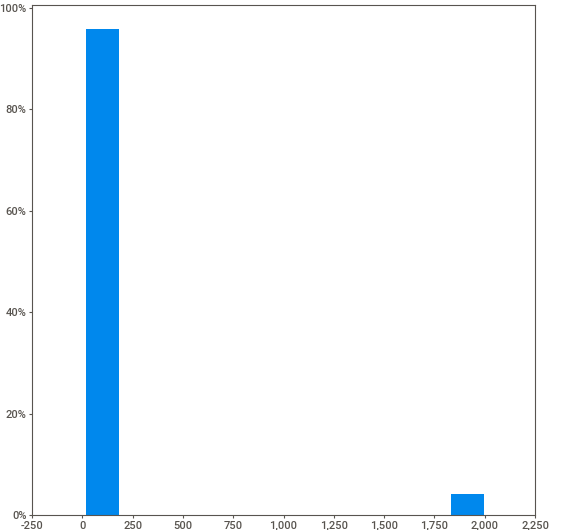
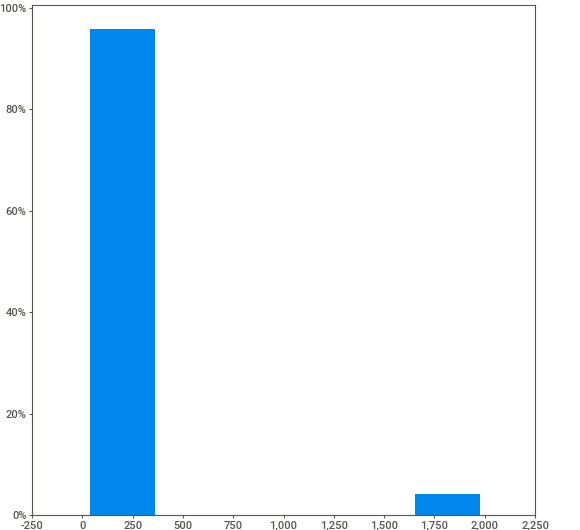
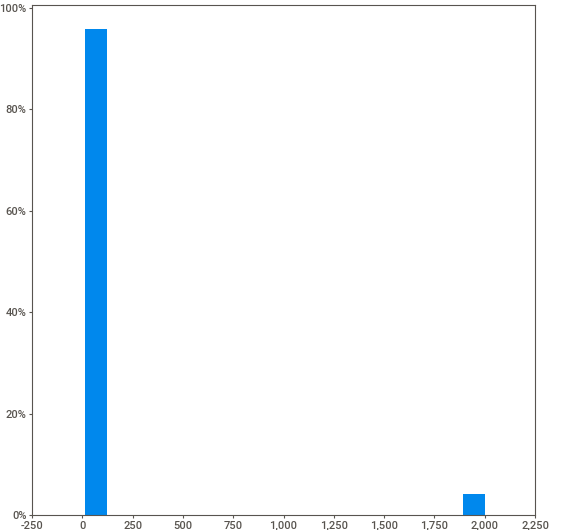
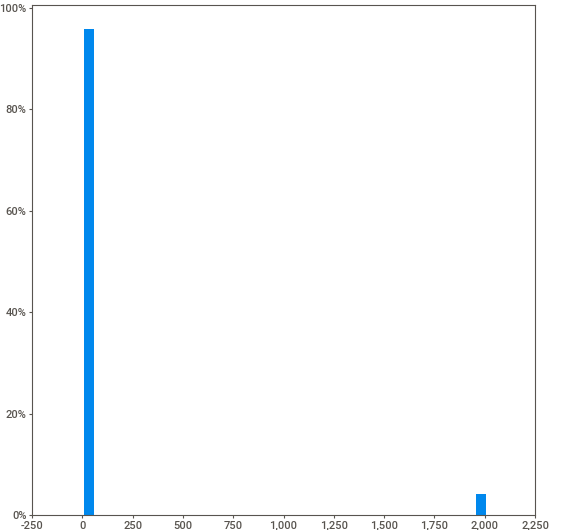
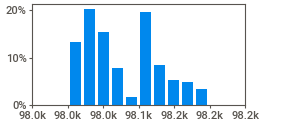
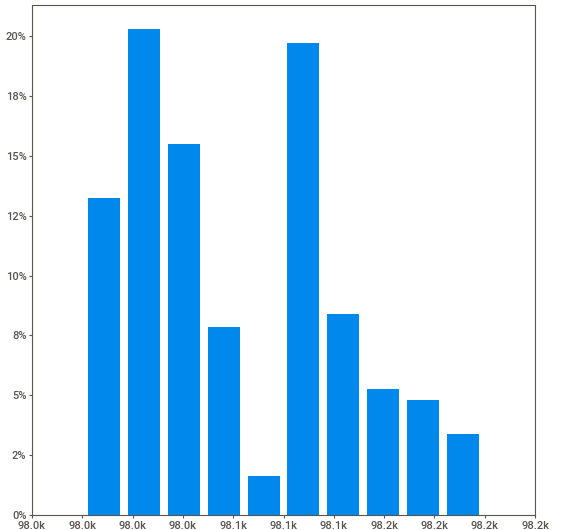
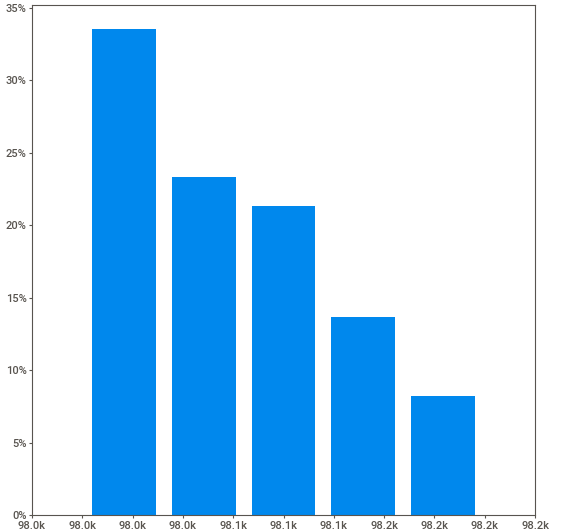
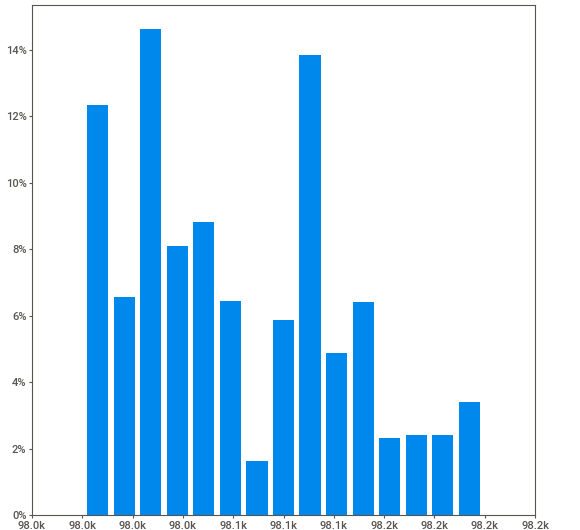
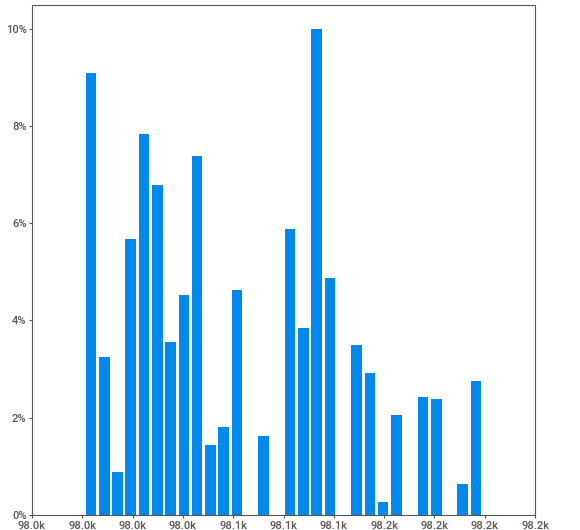
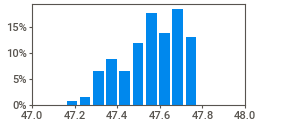
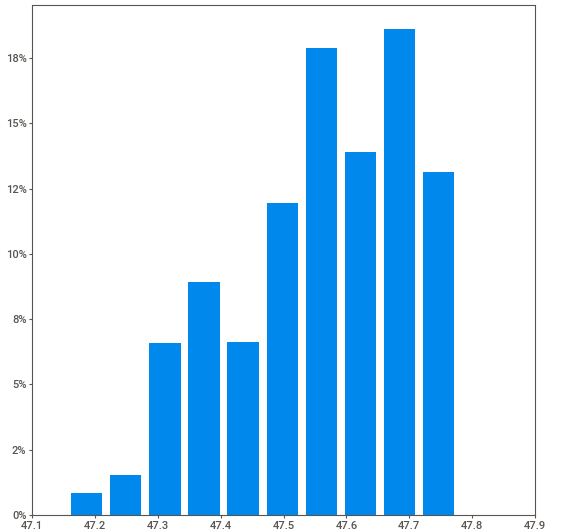
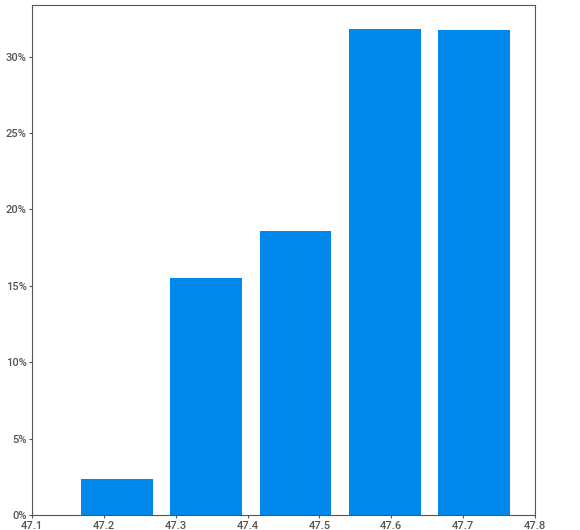
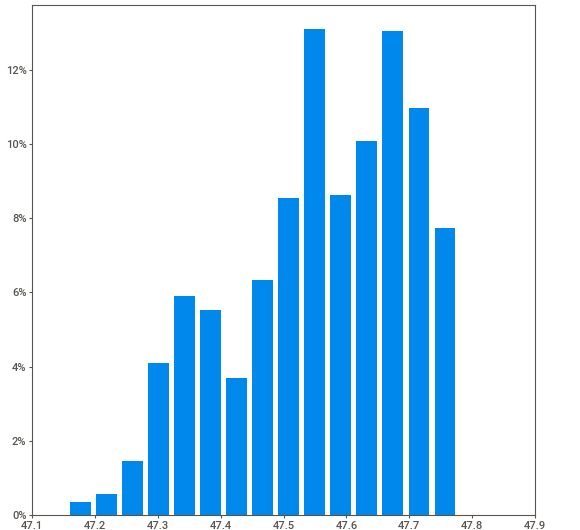
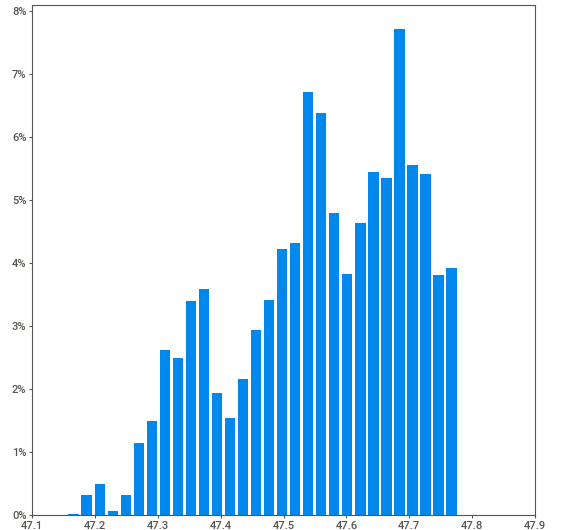
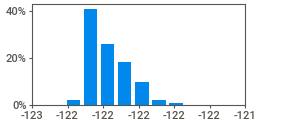
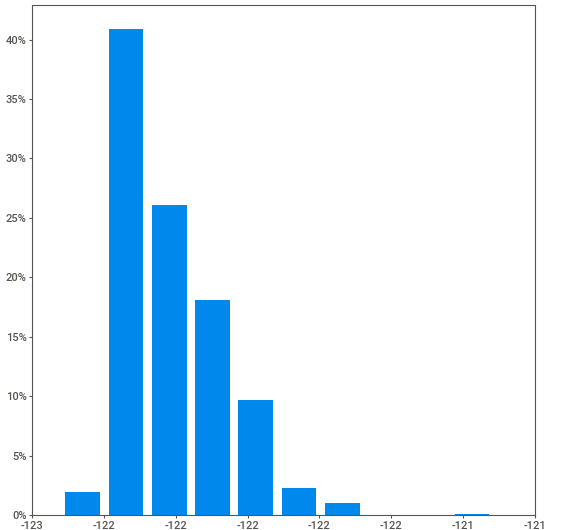
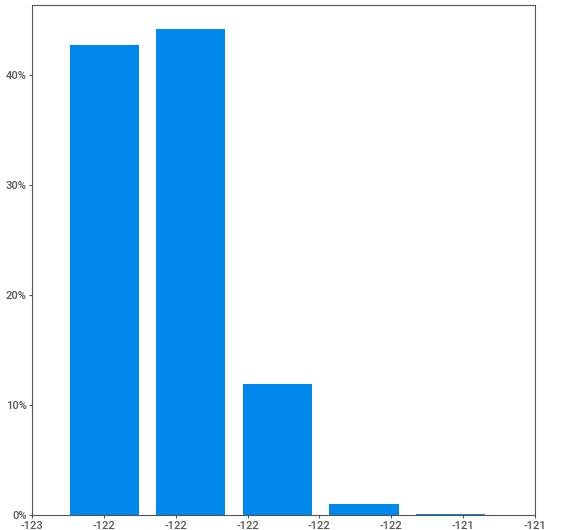
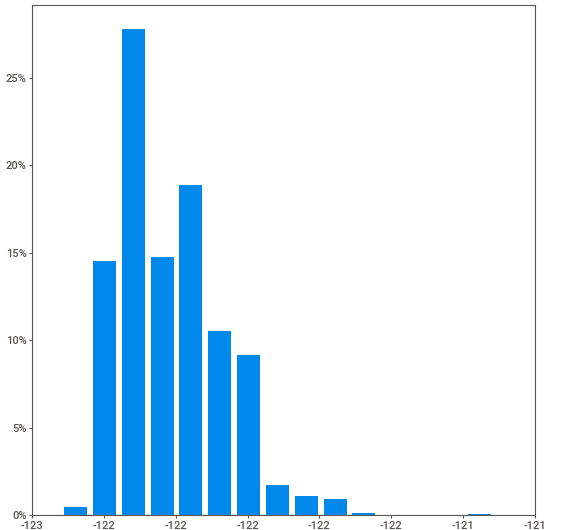
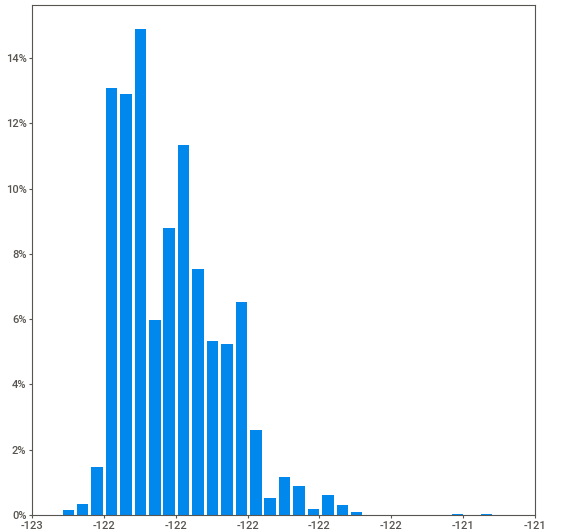
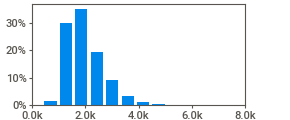
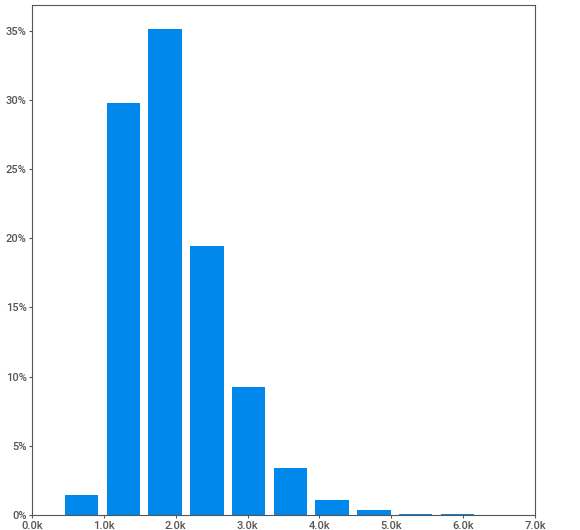
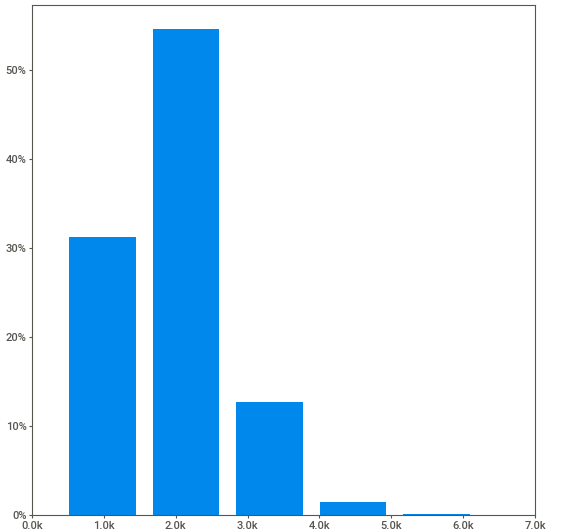
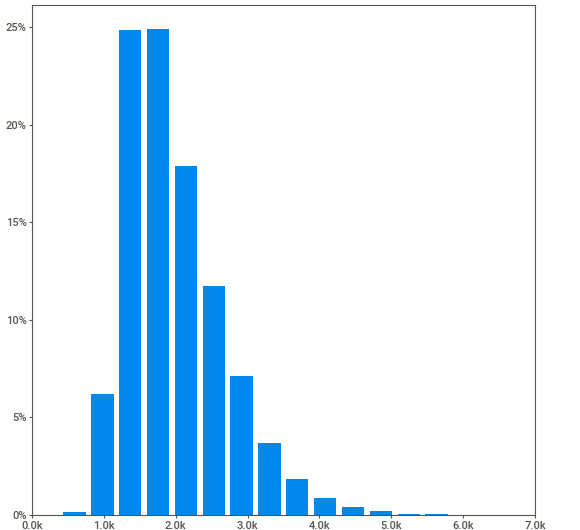
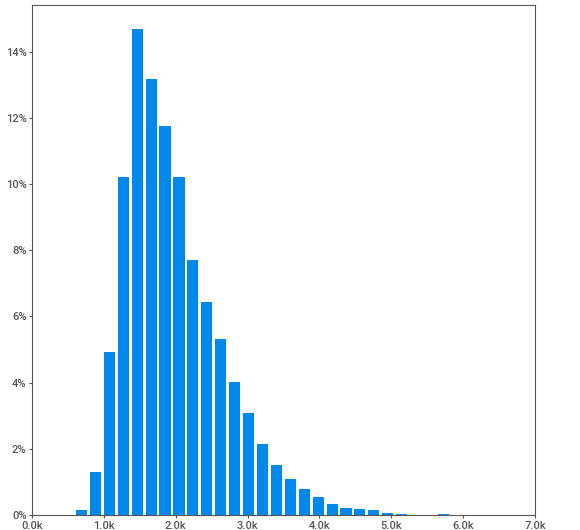
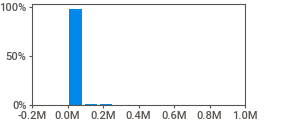
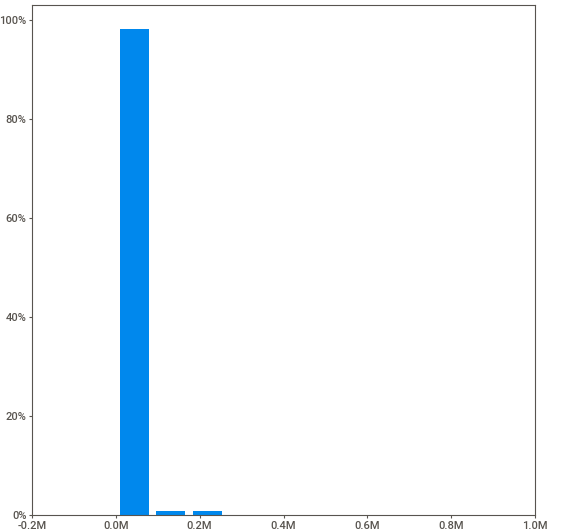
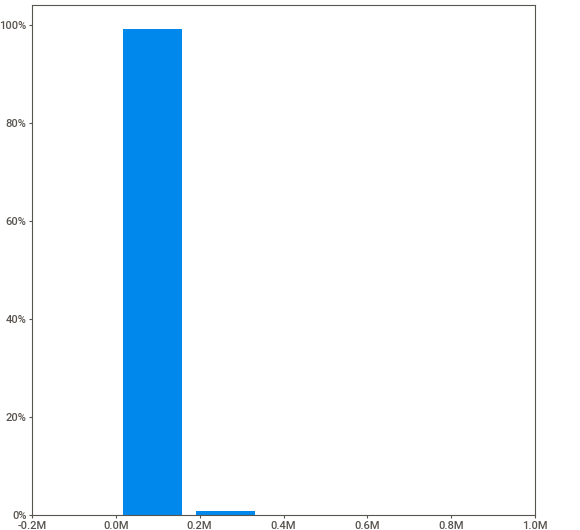
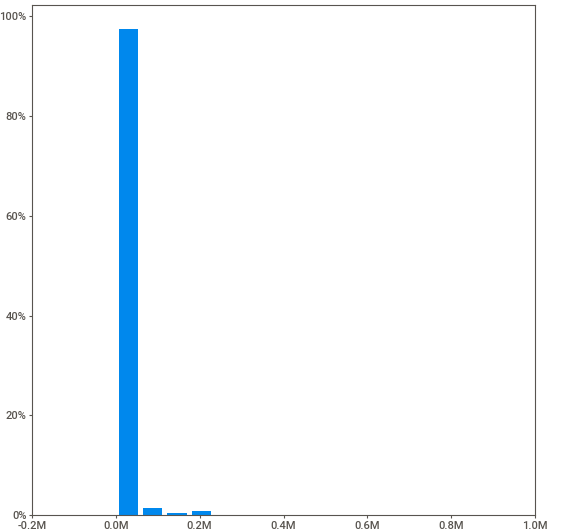
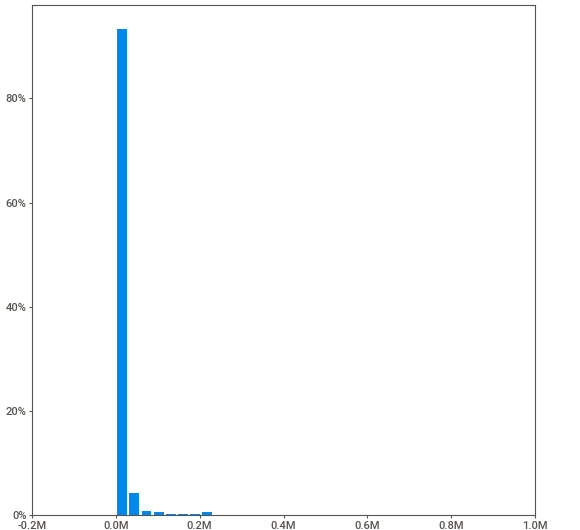
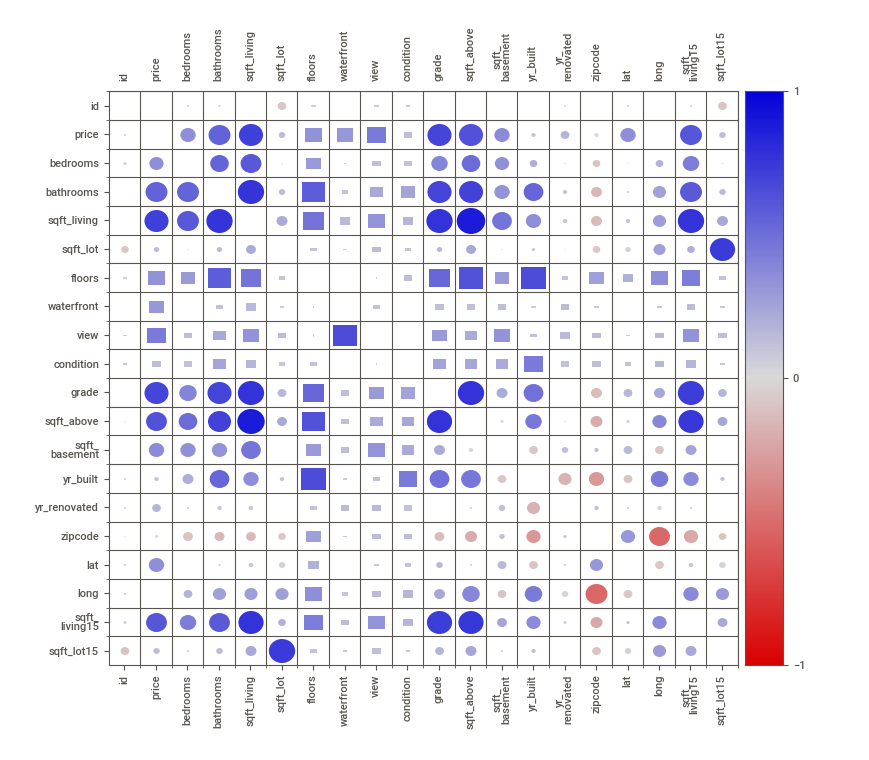
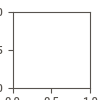

In [294]:
# Visualizing detailed report on features using SweetViz

my_report=sv.analyze(df,pairwise_analysis="on")
# Once the report is recorded there is no necessity in this line 
# my_report.show_html("Reports/exploratory_report.html")
my_report.show_notebook(layout='widescreen', w=1300)

## Find out which ML model that works the best on the raw data

In [5]:
#Defining various models

#1. Linear Regressor model
lr=LinearRegression()

#2. Decision Tree Regressor
dt=DecisionTreeRegressor(random_state=1,criterion='mse',max_depth=10)

#3.Random Forest Regressor
rf=RandomForestRegressor(random_state=1,n_estimators=100,max_depth=10)

#4. KNN
knn=KNeighborsRegressor(n_neighbors=10)

#5.Boosting
grboost=GradientBoostingRegressor(random_state=1)

In [6]:

# define target feature to the y variable
y=df["price"]
# Separate the X variable, the features
X=df.drop(["price","id"],axis=1)

# Split the preprocessed data into a training and testing dataset
# Assign the function a random_state equal to 1
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [7]:

# Create a function that returns train and test accuracy of different models.

def accuracy(model):
    model.fit(X_train,y_train)
    train_accuracy = model.score(X_train, y_train)
    train_accuracy = np.round(train_accuracy*100, 2)
    test_accuracy = model.score(X_test, y_test)
    test_accuracy = np.round(test_accuracy*100, 2)
    return train_accuracy,test_accuracy

In [8]:
# Create DataFrame that illustrates the accuracy of tmodels
accuracy=pd.DataFrame([accuracy(lr), accuracy(dt), accuracy(rf), 
                                           accuracy(knn), accuracy(grboost)])
accuracy.index = ['LinearReg', 'DecisionTree','RandomForest','KNN','GradienBoost']
accuracy.columns=['Train_accuracy(%)','Test_accuracy(%)']
sorted_accuracy_df = accuracy.sort_values(by = 'Train_accuracy(%)', ascending = False)
sorted_accuracy_df

Train_accuracy(%)  Test_accuracy(%)
RandomForest              93.39             85.17
DecisionTree              91.33             80.82
GradienBoost              90.04             85.98
LinearReg                 70.48             68.62
KNN                       61.45             49.07

<AxesSubplot:title={'center':'Accuracy percentage for 5 different ML models'}>

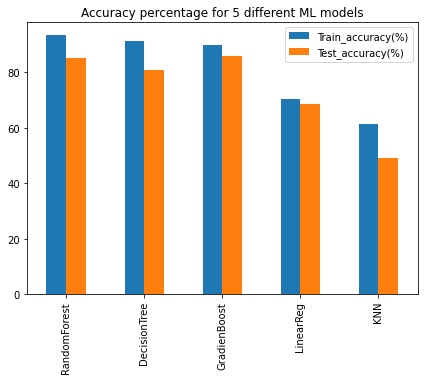

In [9]:
sorted_accuracy_df.plot(legend=True,kind="bar",title="Accuracy percentage for 5 different ML models", figsize=(7,5))


## Random Forests

<AxesSubplot:>

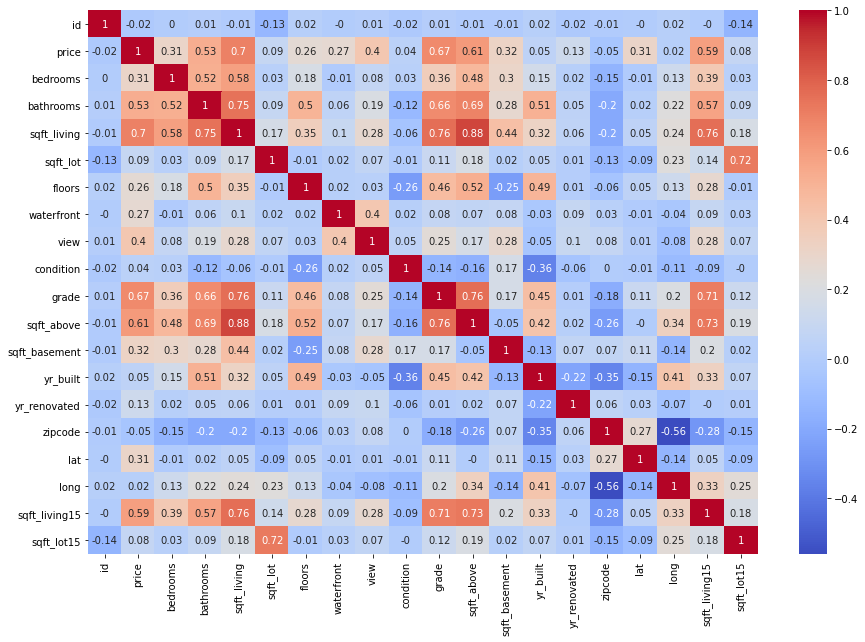

In [58]:
# Visualize the dataset to look for correlations

plt.figure(figsize=(15,10))
sns.heatmap(df.corr().round(2), cmap='coolwarm',annot=True)

In [59]:
# Convert 'zipcode' to categorical
df['zipcode'] = df.zipcode.astype('category')

<AxesSubplot:title={'center':'Median price by months'}, xlabel='date'>

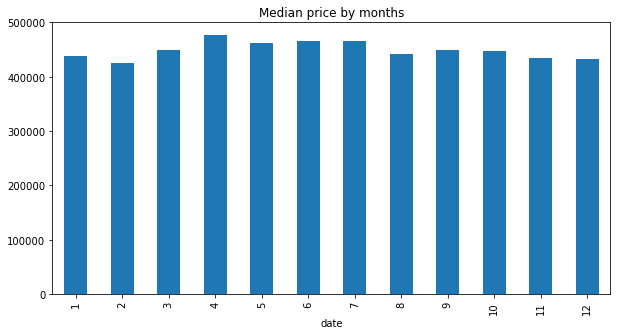

In [60]:
# visualize the price vs date sold
df['price'].groupby(df.index.month).median().plot(kind="bar",title="Median price by months",figsize=(10,5))


In [61]:
# Create the features and target datasets
X = df.drop(columns=['price'])
y = df['price']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [63]:
# fitting data 
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
y_pred=model_rf.predict(X_test)
print(f"After converting 'zipcode' into categorical the accuracy for training data is equal to {model_rf.score(X_train,y_train)}")
print(f"After converting 'zipcode' into categorical the accuracy for testing data is equal to {model_rf.score(X_test,y_test)}")

print("-------")
print(f"The R-squared for Random Forest is {r2_score(y_test,y_pred)}")
print(f"The Mean absolute error for Random Forest Regression is {mean_absolute_error(y_test,y_pred)}")
print(f"The Mean absolute percentage error for Random Forest Regression is {mean_absolute_percentage_error(y_test,y_pred)}")

After converting 'zipcode' into categorical the accuracy for training data is equal to 0.9808017233627675
After converting 'zipcode' into categorical the accuracy for testing data is equal to 0.8912035403915095
-------
The R-squared for Random Forest is 0.8912035403915095
The Mean absolute error for Random Forest Regression is 67774.48115279002
The Mean absolute percentage error for Random Forest Regression is 0.13148101653729422


In [49]:
# # Create a funtction to determine the importance of each feature in predicting the sale price
def feat_importance(model, X):
    importance = model.feature_importances_
    importance = pd.DataFrame(importance, index=X.columns, columns=['Importance'])
    return importance.sort_values(by=['Importance'], ascending=False)


#### Importance of features for the Random Forest model

In [50]:
importance = feat_importance(model_rf, X_train)
importance

Importance
grade            0.297728
sqft_living      0.292137
lat              0.149071
long             0.069705
sqft_living15    0.034019
waterfront       0.029066
yr_built         0.022530
sqft_above       0.021245
zipcode          0.013910
sqft_lot15       0.012084
sqft_lot         0.011559
view             0.011129
id               0.009740
bathrooms        0.009227
sqft_basement    0.007002
bedrooms         0.003277
condition        0.002914
floors           0.001860
yr_renovated     0.001798

#### Based on feature importances data dropping the least affecting features

In [64]:
# Create new DataFrame with fewer features. Dropping all features with an importance less than .01.
df_trimmed = df.drop(columns=['id','bathrooms','sqft_basement','condition','bedrooms','yr_renovated','floors'])

In [65]:
# Create the new features and target datasets

X = df_trimmed.drop(columns=['price'])
y = df_trimmed['price']
X

sqft_living  sqft_lot  waterfront  view  grade  sqft_above  \
date                                                                     
2014-10-13         1180      5650           0     0      7        1180   
2014-12-09         2570      7242           0     0      7        2170   
2015-02-25          770     10000           0     0      6         770   
2014-12-09         1960      5000           0     0      7        1050   
2015-02-18         1680      8080           0     0      8        1680   
...                 ...       ...         ...   ...    ...         ...   
2014-05-21         1530      1131           0     0      8        1530   
2015-02-23         2310      5813           0     0      8        2310   
2014-06-23         1020      1350           0     0      7        1020   
2015-01-16         1600      2388           0     0      8        1600   
2014-10-15         1020      1076           0     0      7        1020   

            yr_built zipcode      lat     long  sqft_living15  sqft_lot15  
date                                                                       
2014-10-13      1955   98178  47.5112 -122.257           1340        5650  
2014-12-09      1951   98125  47.7210 -122.319           1690        7639  
2015-02-25      1933   98028  47.7379 -122.233           2720        8062  
2014-12-09      1965   98136  47.5208 -122.393           1360        5000  
2015-02-18      1987   98074  47.6168 -122.045           1800        7503  
...              ...     ...      ...      ...            ...         ...  
2014-05-21      2009   98103  47.6993 -122.346           1530        1509  
2015-02-23      2014   98146  47.5107 -122.362           1830        7200  
2014-06-23      2009   98144  47.5944 -122.299           1020        2007  
2015-01-16      2004   98027  47.5345 -122.069           1410        1287  
2014-10-15      2008   98144  47.5941 -122.299           1020        1357  

[21613 rows x 12 columns]

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [67]:
model = RandomForestRegressor()
model.fit(X_train, y_train)


RandomForestRegressor()

In [68]:
y_pred=model.predict(X_test)
print(f"After dropping columns the accuracy for training data is equal to {model.score(X_train,y_train)}")
print(f"After dropping columns the accuracy for testing data is equal to {model.score(X_test,y_test)}")

print("-------")
print(f"The R-squared for Random Forest is {r2_score(y_test,y_pred)}")
print(f"The Mean absolute error for Random Forest Regression is {mean_absolute_error(y_test,y_pred)}")
print(f"The Mean absolute percentage error for Random Forest Regression is {mean_absolute_percentage_error(y_test,y_pred)}")


After dropping columns the accuracy for training data is equal to 0.9822738958656494
After dropping columns the accuracy for testing data is equal to 0.8808315792259073
-------
The R-squared for Random Forest is 0.8808315792259073
The Mean absolute error for Random Forest Regression is 69010.6151855887
The Mean absolute percentage error for Random Forest Regression is 0.13116249461585489


## Exploratory Data Analysis

In [336]:
df = pd.read_csv(Path('Data/kc_house_data.csv'))

In [337]:
#### Working with features

In [339]:
# Splitting the "date" column into 2 different values- month,quarter
new_df=df.copy()
new_df["date"]=pd.to_datetime(new_df["date"])
new_df["month"]=pd.DatetimeIndex(new_df['date']).month
new_df["quarter"]=pd.DatetimeIndex(new_df['date']).quarter

In [340]:
new_df=new_df.drop("date",axis=1)

In [341]:
# exploring square footage
new_df[["sqft_above","sqft_basement","sqft_living","sqft_lot","sqft_living15","sqft_lot15"]].head()

sqft_above  sqft_basement  sqft_living  sqft_lot  sqft_living15  sqft_lot15
0        1180              0         1180      5650           1340        5650
1        2170            400         2570      7242           1690        7639
2         770              0          770     10000           2720        8062
3        1050            910         1960      5000           1360        5000
4        1680              0         1680      8080           1800        7503

In [342]:
#Price per sqft per house and per living area
# After calculatingdrop sqft above,sqft_basement
new_df["p_per_sqft_overall"]=new_df["price"]/(new_df["sqft_living"]+new_df["sqft_lot"])
new_df["p_per_sqft_living"]=new_df["price"]/(new_df["sqft_above"]+new_df["sqft_basement"])

In [343]:
# Since the "sqft_living"="sqft_above"+"sqft_basement"
new_df=new_df.drop(["sqft_above","sqft_basement"],axis=1)


In [344]:
# new_df['yr_built'] = new_df.yr_built.astype('category')
# new_df['yr_renovated'] = new_df.yr_renovated.astype('category')
# new_df['month'] = new_df.month.astype('category')
# new_df['quarter'] = new_df.quarter.astype('category')

In [346]:
new_df.groupby("floors").median().hvplot(title="Median sales prices of houses with various floors",kind="bar",x="floors",y="price",width=500,height=300)

:Bars   [floors]   (price)

In [404]:
print(new_df["bedrooms"].value_counts())
new_df=new_df.drop(new_df.loc[new_df["bedrooms"].values>=10,:].index,axis=0)
new_df.groupby("bedrooms").median().hvplot(title="Median sales prices of houses with different # of bedrooms",kind="bar",x="bedrooms",y="price", width=600,height=300)

3    9824
4    6882
2    2760
5    1601
6     272
1     199
7      38
0      13
8      13
9       6
Name: bedrooms, dtype: int64


:Bars   [bedrooms]   (price)

In [405]:
new_df.groupby("bedrooms").median().hvplot(title="Median sales prices of houses with different # of bathrooms",kind="bar",x="bathrooms",y="price", width=600,height=300)

:Bars   [bathrooms]   (price)

In [350]:
# new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21608 entries, 0 to 21612
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  21608 non-null  int64  
 1   price               21608 non-null  float64
 2   bedrooms            21608 non-null  int64  
 3   bathrooms           21608 non-null  float64
 4   sqft_living         21608 non-null  int64  
 5   sqft_lot            21608 non-null  int64  
 6   floors              21608 non-null  float64
 7   waterfront          21608 non-null  int64  
 8   view                21608 non-null  int64  
 9   condition           21608 non-null  int64  
 10  grade               21608 non-null  int64  
 11  yr_built            21608 non-null  int64  
 12  yr_renovated        21608 non-null  int64  
 13  zipcode             21608 non-null  int64  
 14  lat                 21608 non-null  float64
 15  long                21608 non-null  float64
 16  sqft

In [352]:
new_df.hvplot(kind="scatter",title="Price correlation to Square footage of living space",figsize=(10,5),x="sqft_living",c="long",y="price")

:Scatter   [sqft_living]   (price,long)

In [353]:
# # Convert 'zipcode' to categorical
# df['zipcode'] = df.zipcode.astype('category')
# df['zipcode']
# Encoding the categorical feature "zipcode"  

map_dict = {n + 1: cat for n, cat in enumerate(new_df["zipcode"].astype('category').cat.categories)}
new_df["zipcode"] = pd.DataFrame(new_df["zipcode"].astype('category').cat.codes + 1, index=new_df.index)

### Data split and scaling

In [406]:
# Separate the y variable, the labels
new_df.reset_index(drop=True, inplace=True)
y=new_df["price"]
# Separate the X variable, the features
X=new_df.drop(["price","id"],axis=1)


bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0         3       1.00         1180      5650     1.0           0     0   
1         3       2.25         2570      7242     2.0           0     0   
2         2       1.00          770     10000     1.0           0     0   
3         4       3.00         1960      5000     1.0           0     0   
4         3       2.00         1680      8080     1.0           0     0   

   condition  grade  yr_built  yr_renovated  zipcode      lat     long  \
0          3      7      1955             0       67  47.5112 -122.257   
1          3      7      1951          1991       56  47.7210 -122.319   
2          3      6      1933             0       17  47.7379 -122.233   
3          5      7      1965             0       59  47.5208 -122.393   
4          3      8      1987             0       38  47.6168 -122.045   

   sqft_living15  sqft_lot15  month  quarter  p_per_sqft_overall  \
0           1340        5650     10        4           32.489019   
1           1690        7639     12        4           54.830819   
2           2720        8062      2        1           16.713092   
3           1360        5000     12        4           86.781609   
4           1800        7503      2        1           52.254098   

   p_per_sqft_living  
0         188.050847  
1         209.338521  
2         233.766234  
3         308.163265  
4         303.571429

In [407]:
# Split the preprocessed data into a training and testing dataset
# Assign the function a random_state equal to 1

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

                                             |          | [  0%]   00:00 -> (? left)

Report Reports/comparison_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



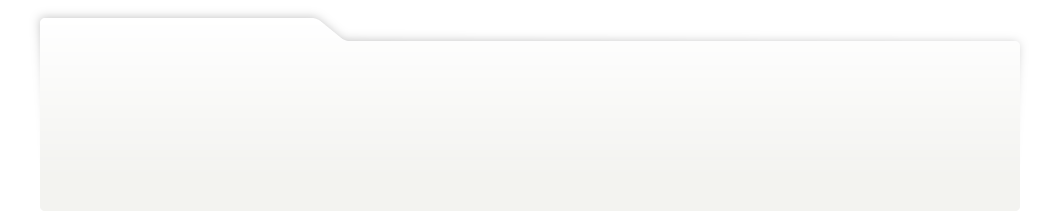
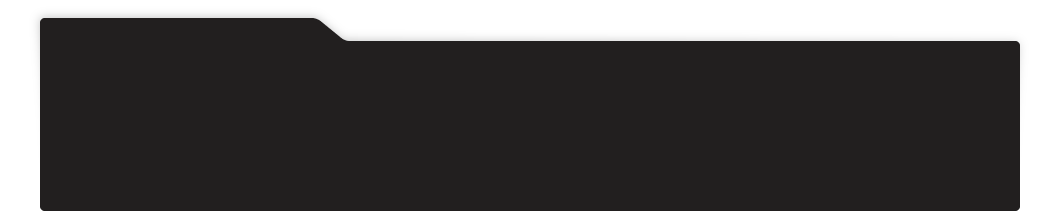
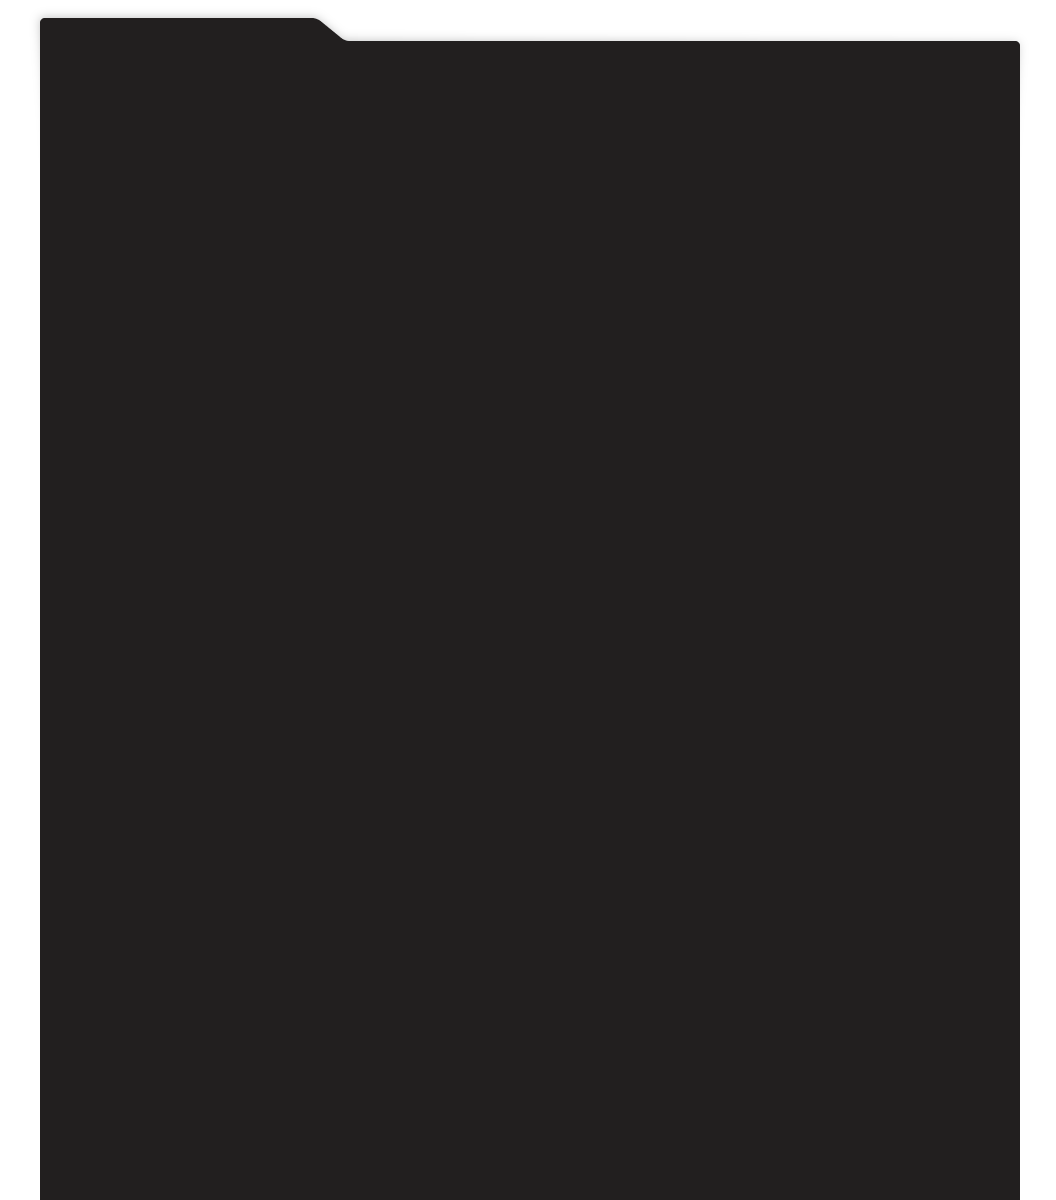
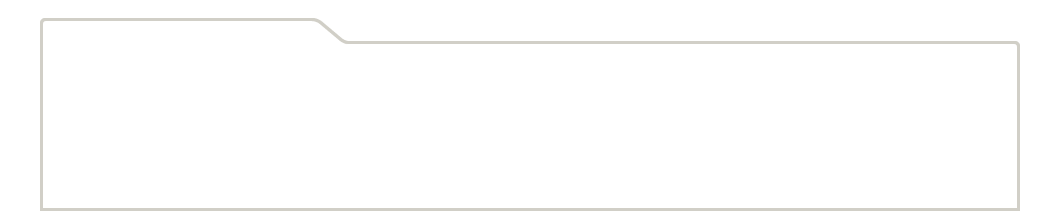
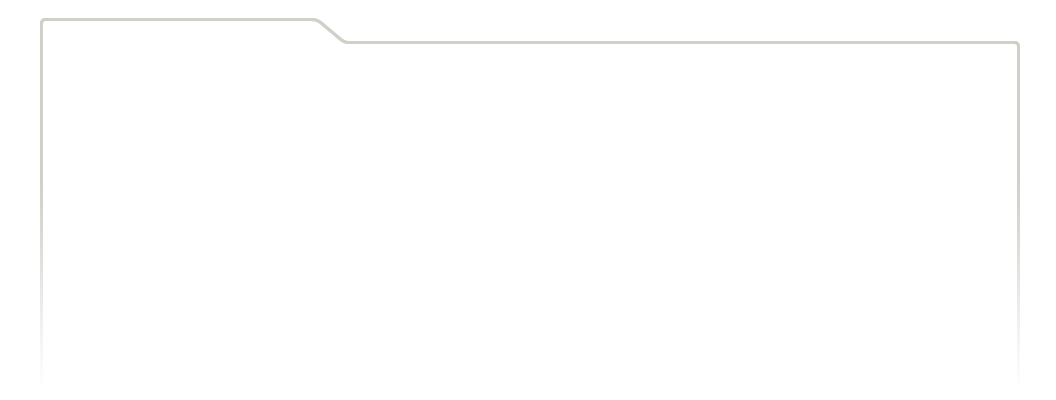
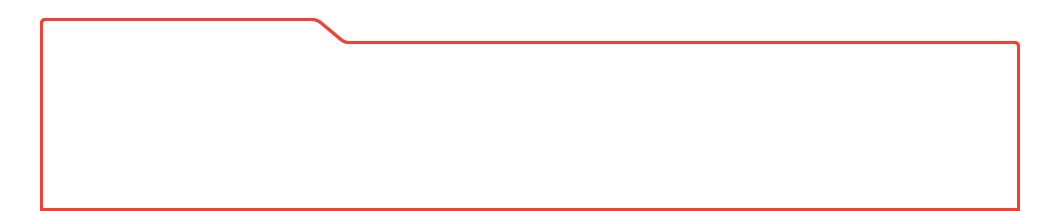
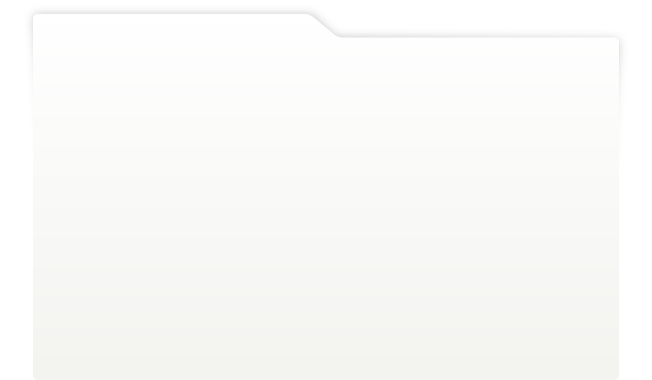
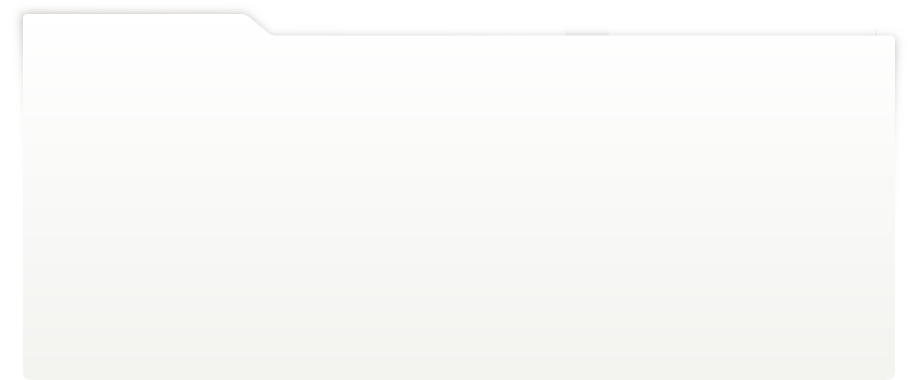
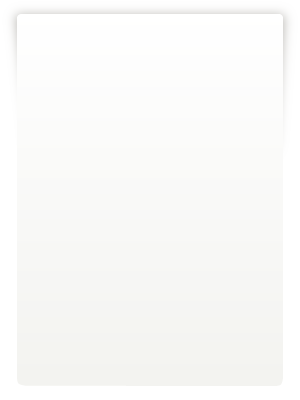
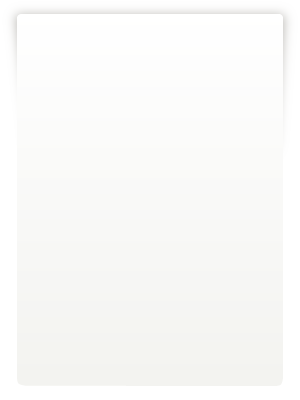
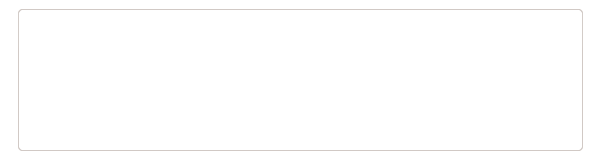
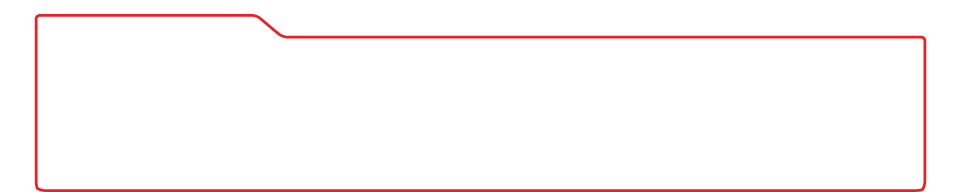
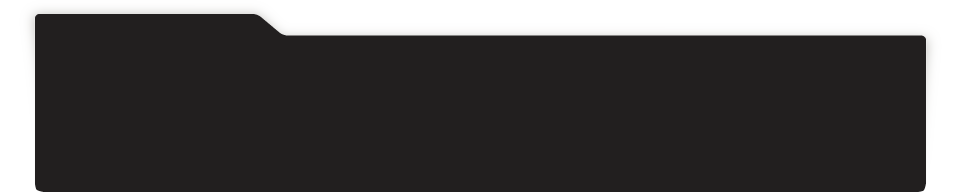
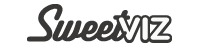
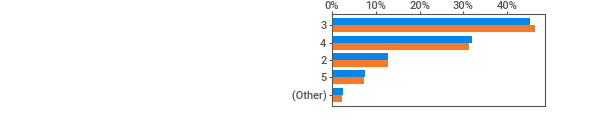
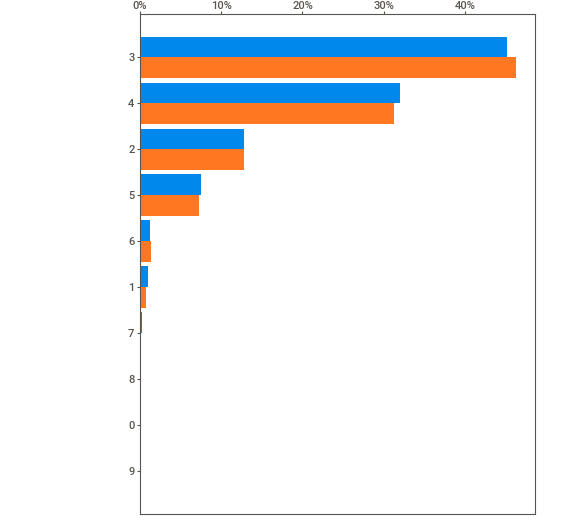
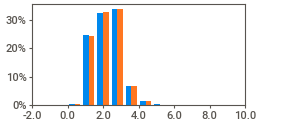
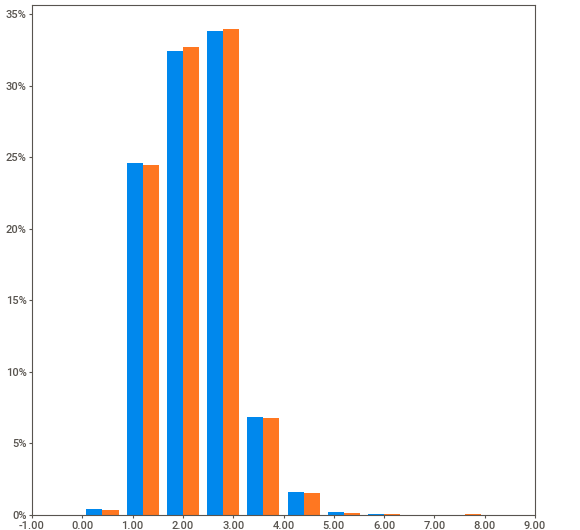
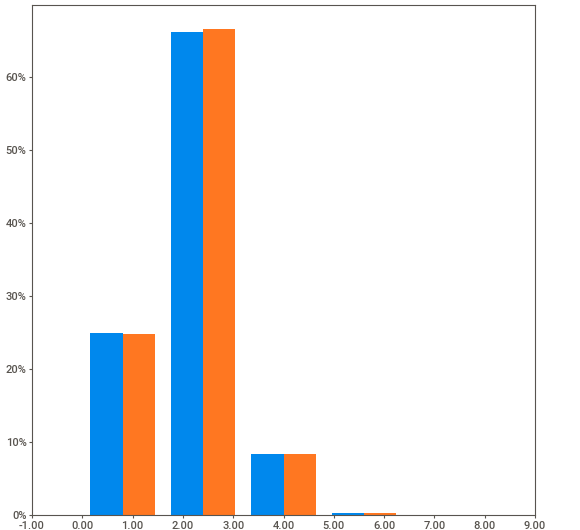
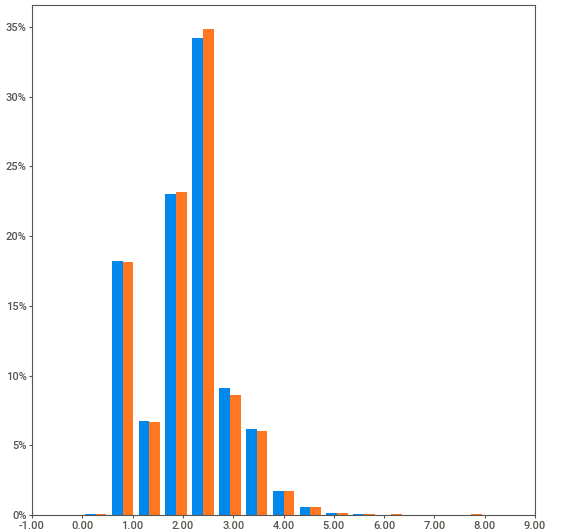
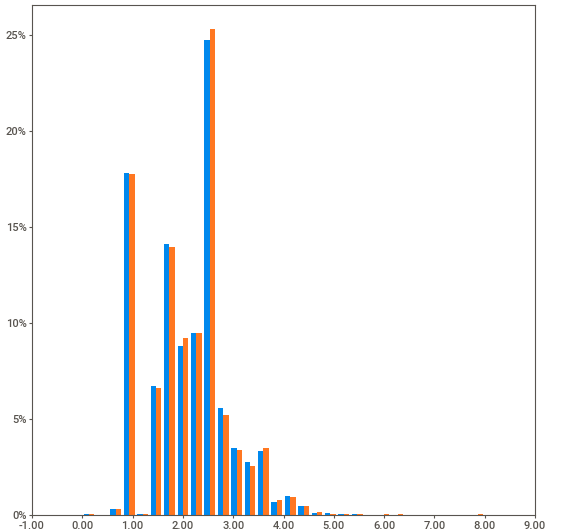
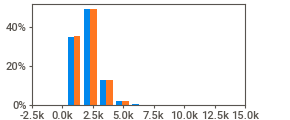
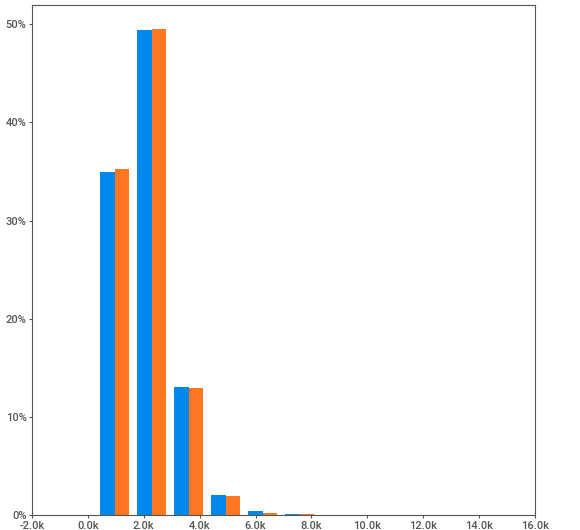
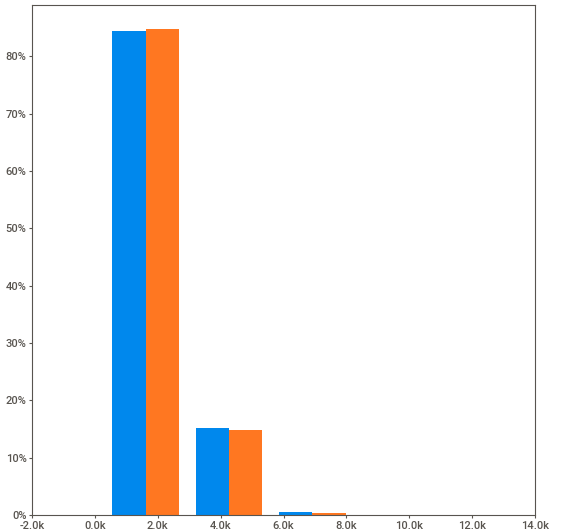
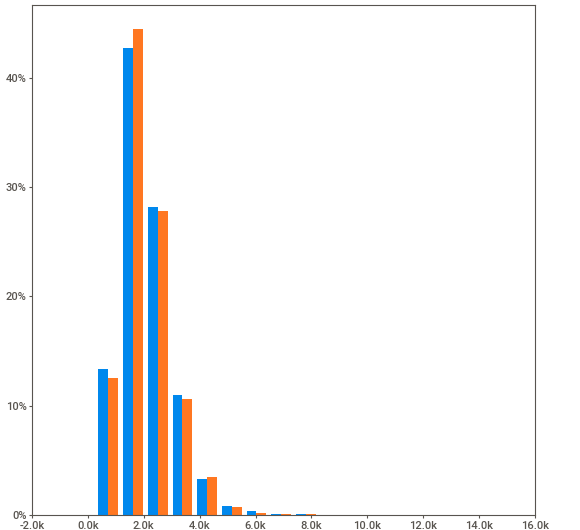
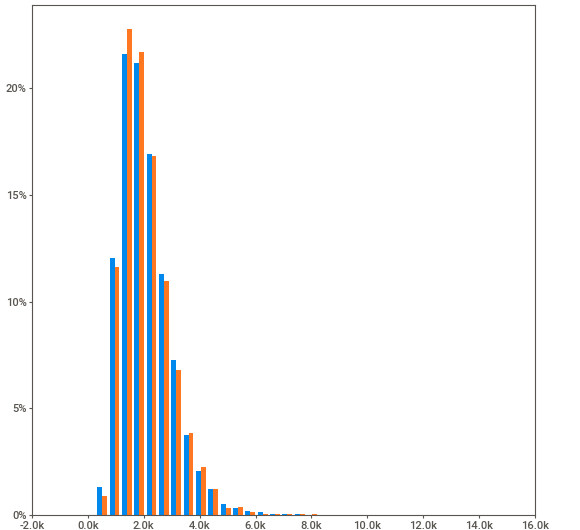
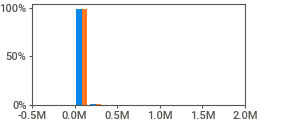
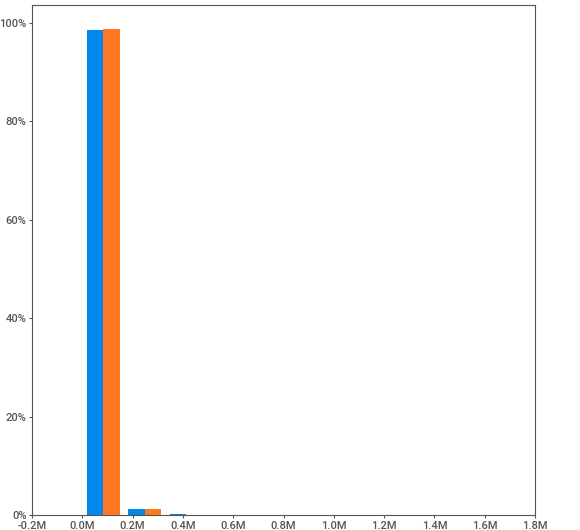
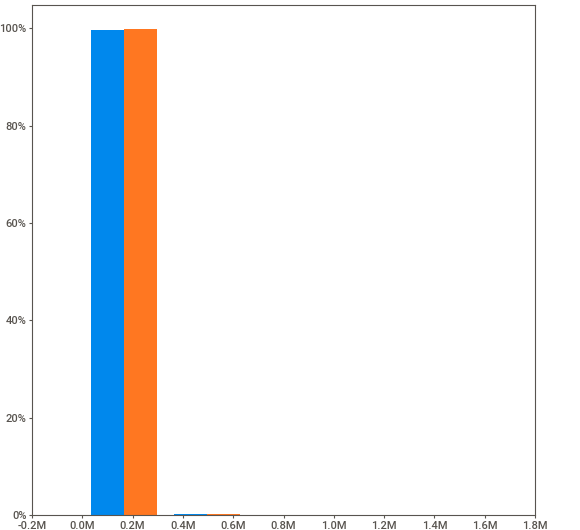
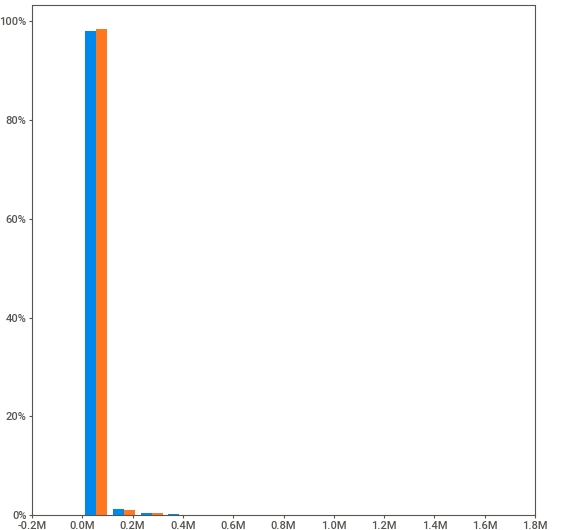
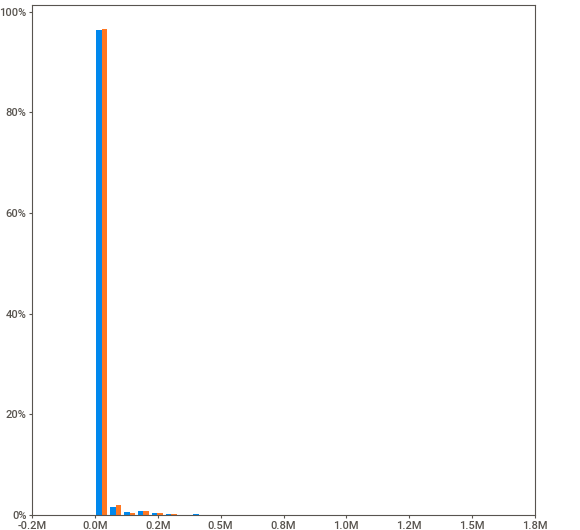
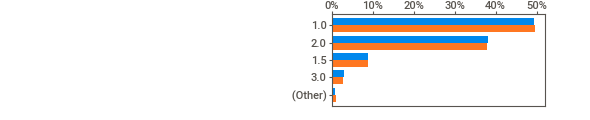
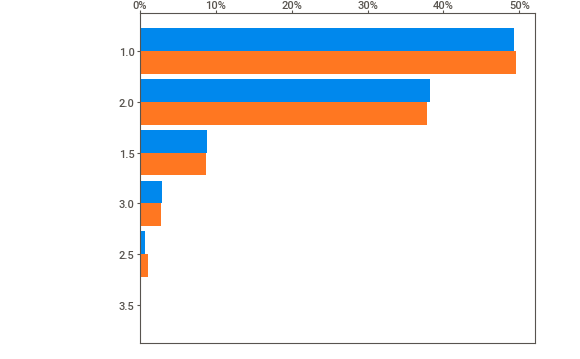
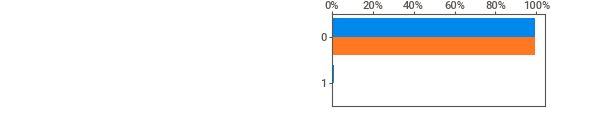
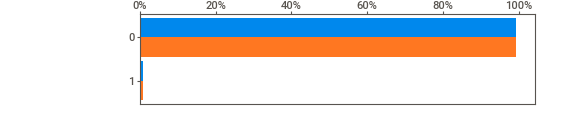
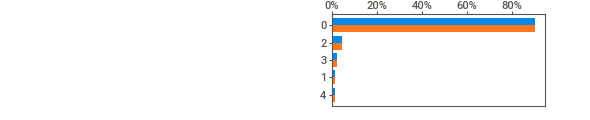
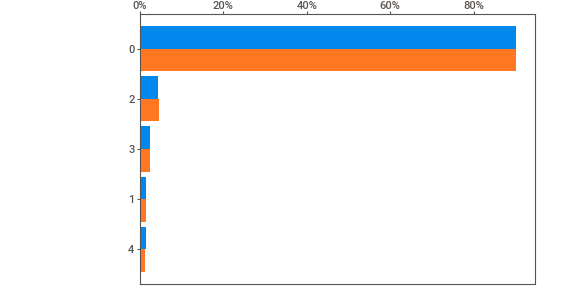
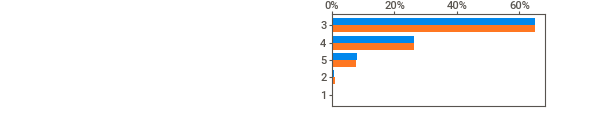
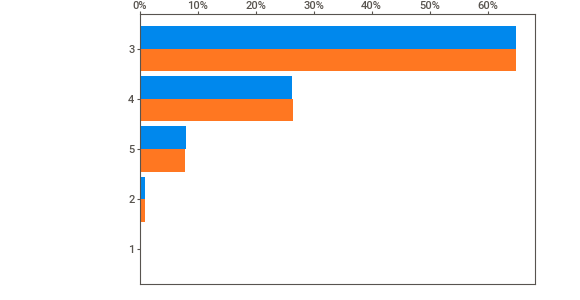
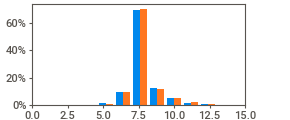
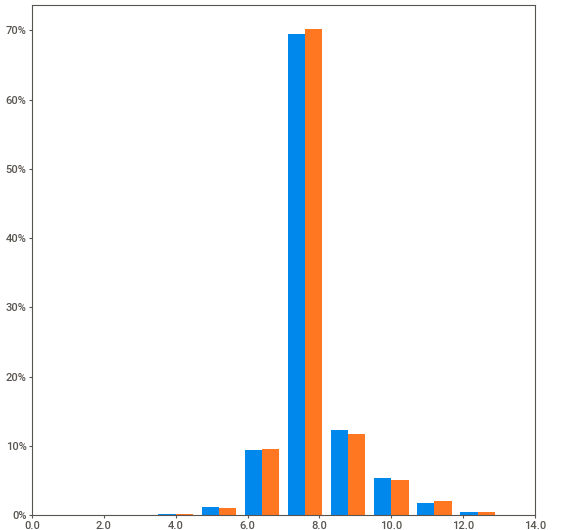
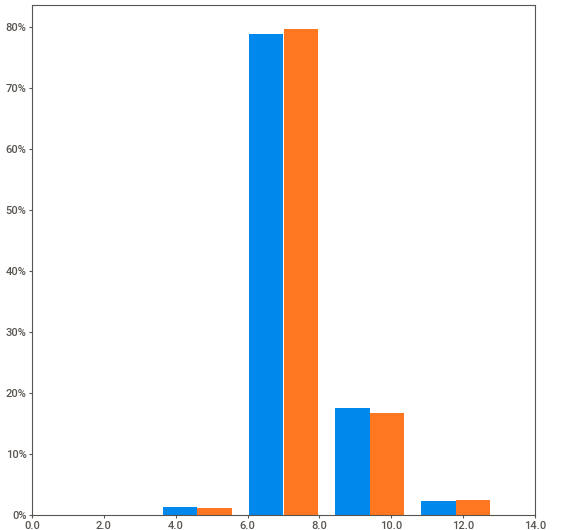
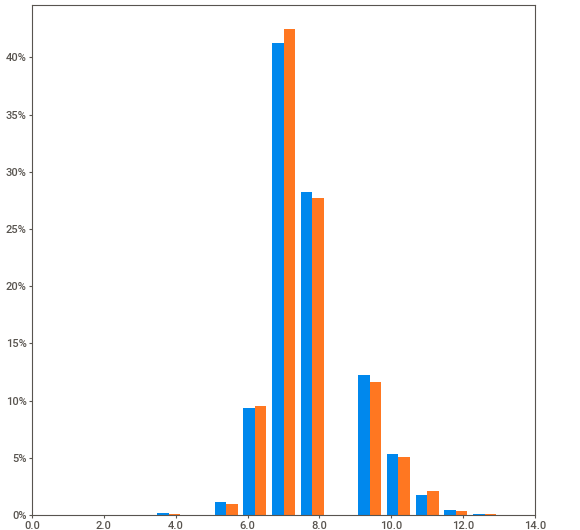
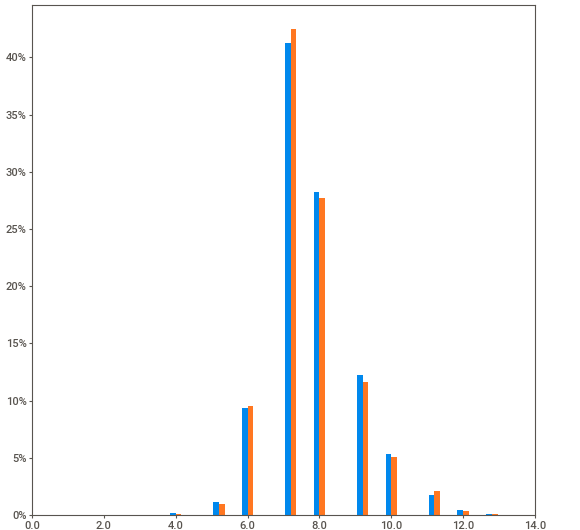
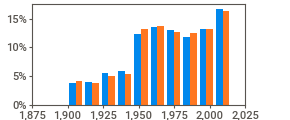
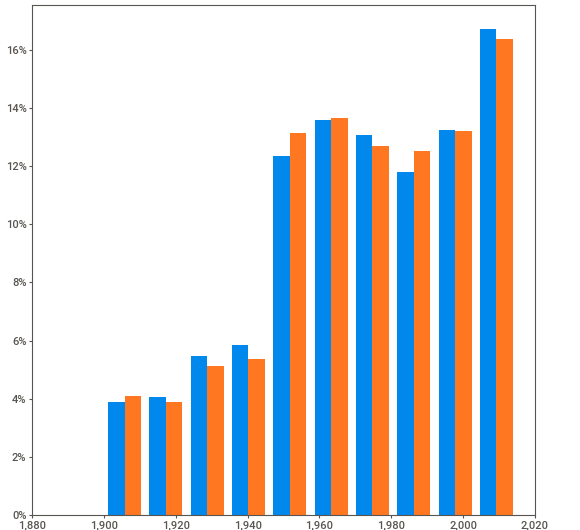
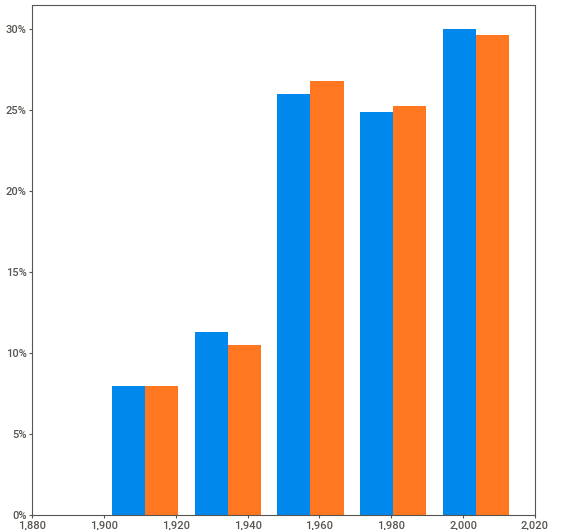
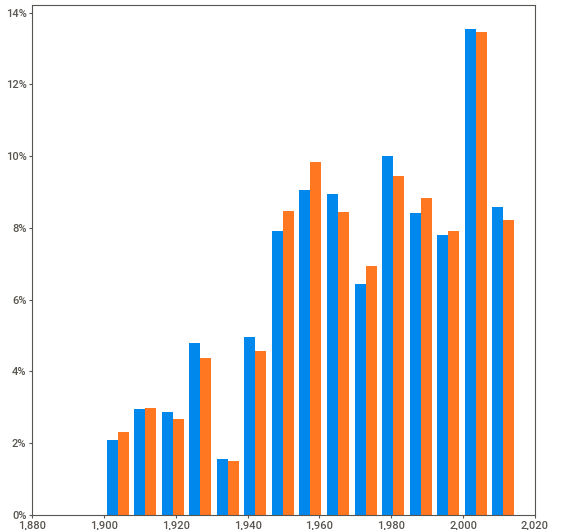
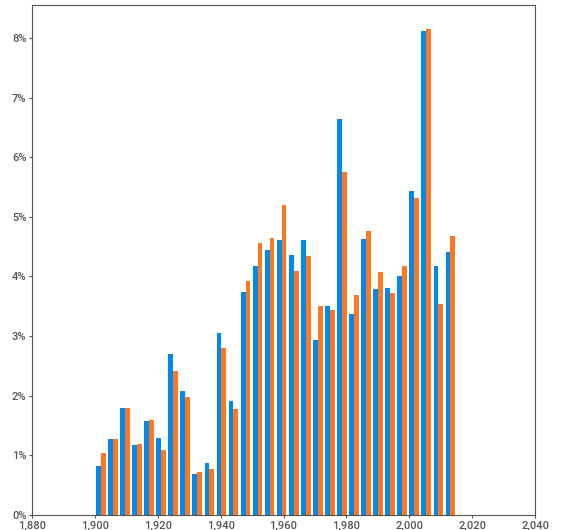
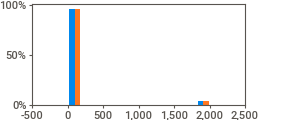
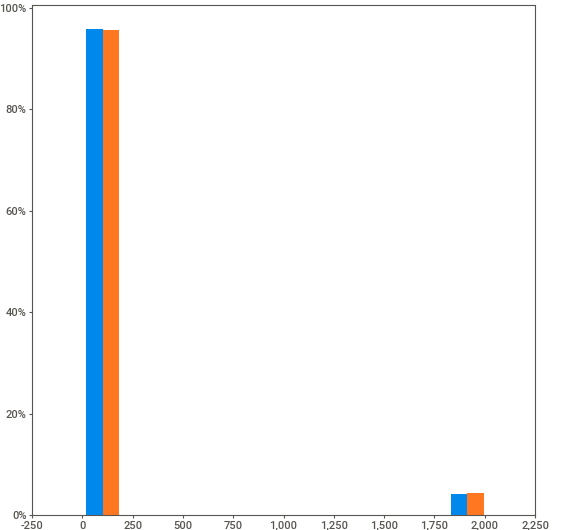
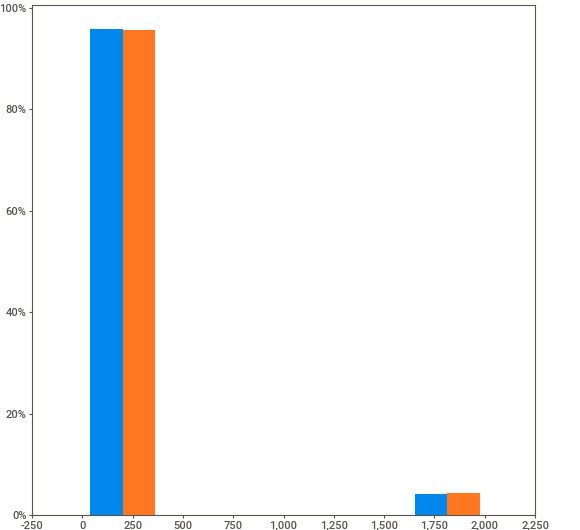
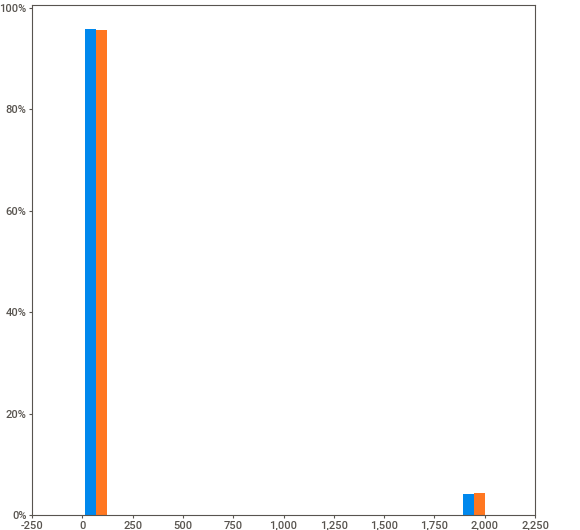
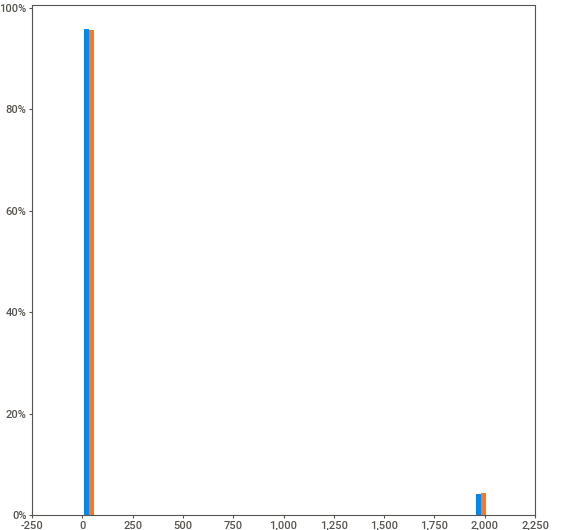
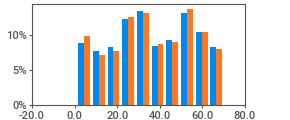
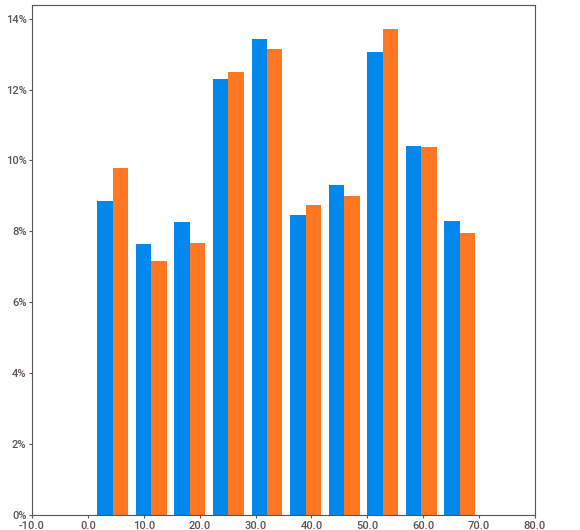
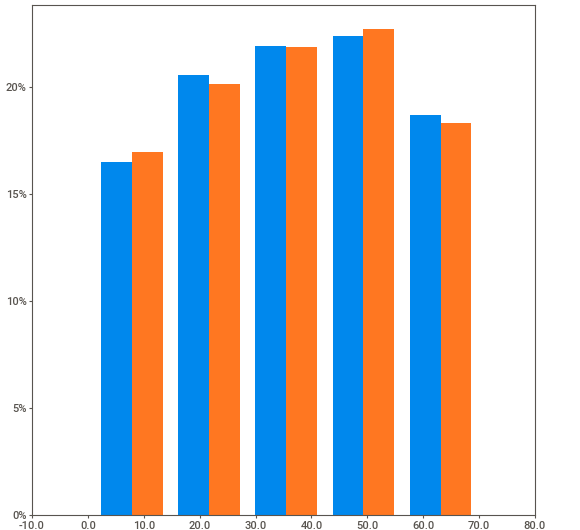
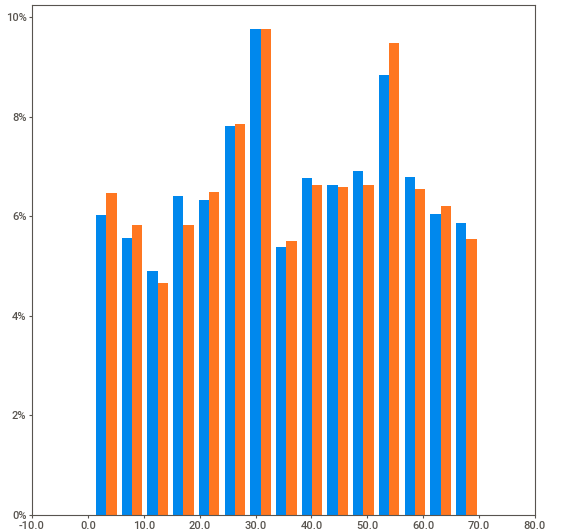
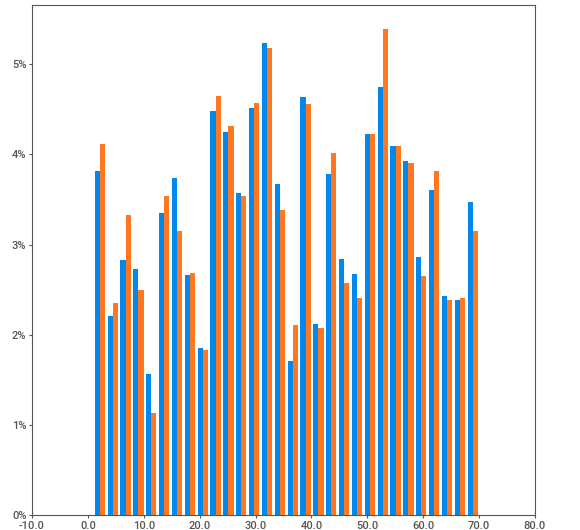
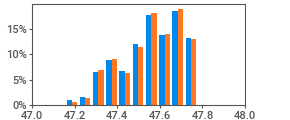
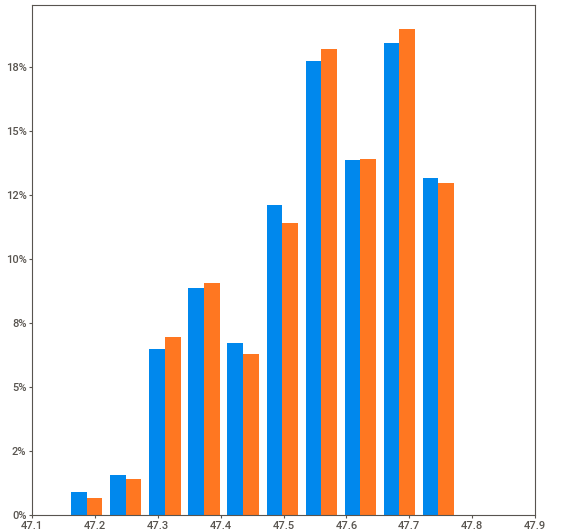
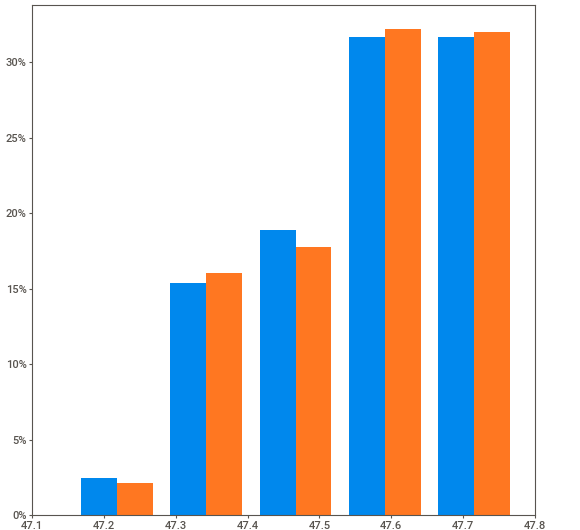
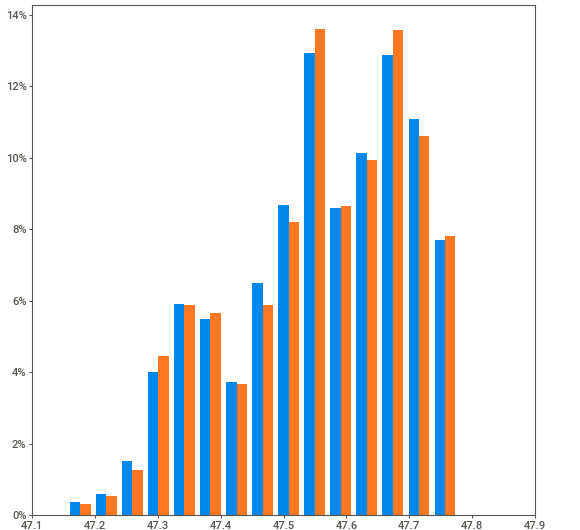
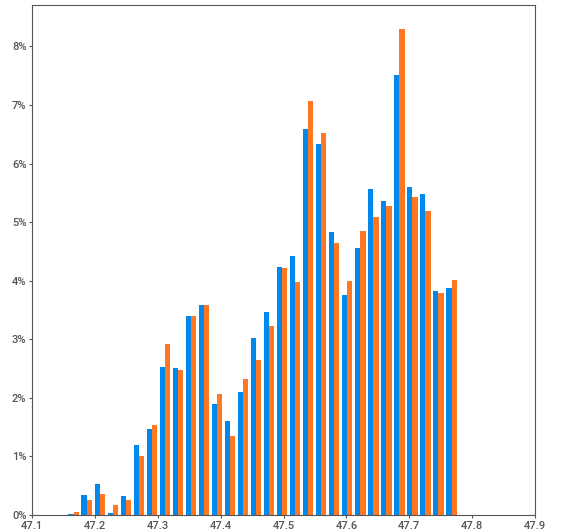
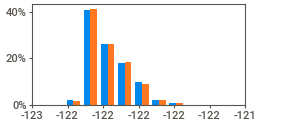
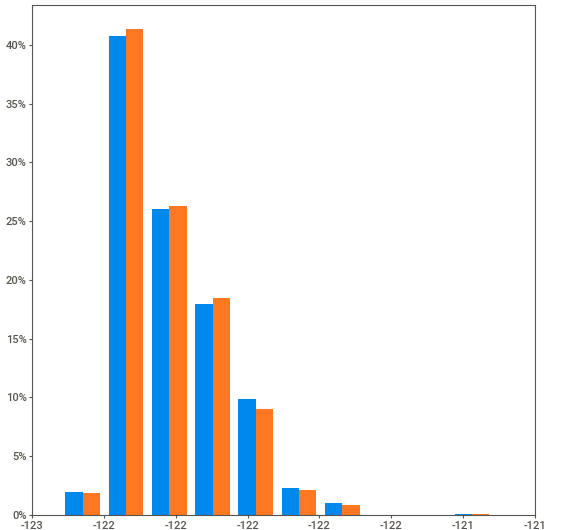
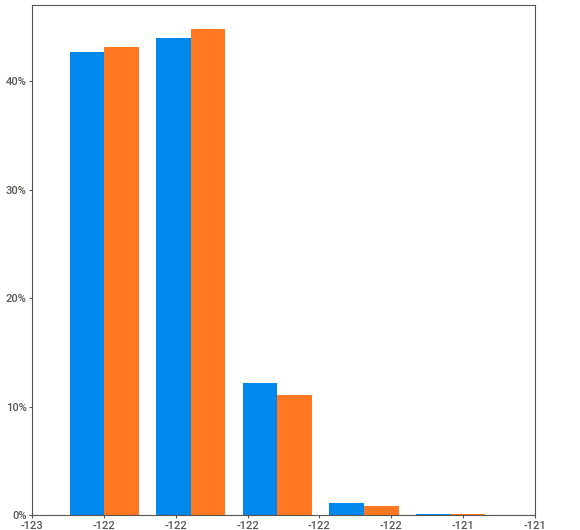
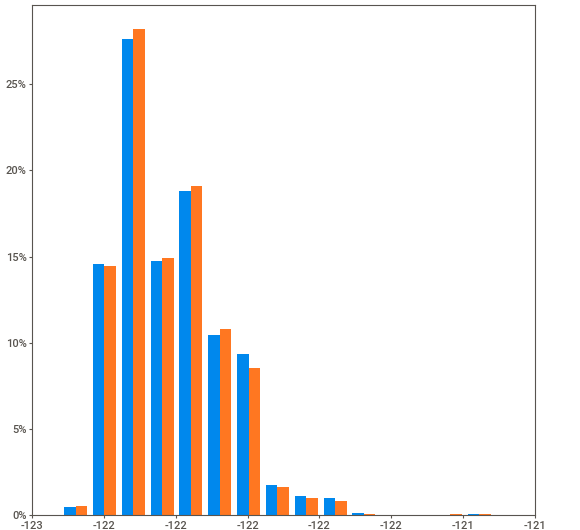
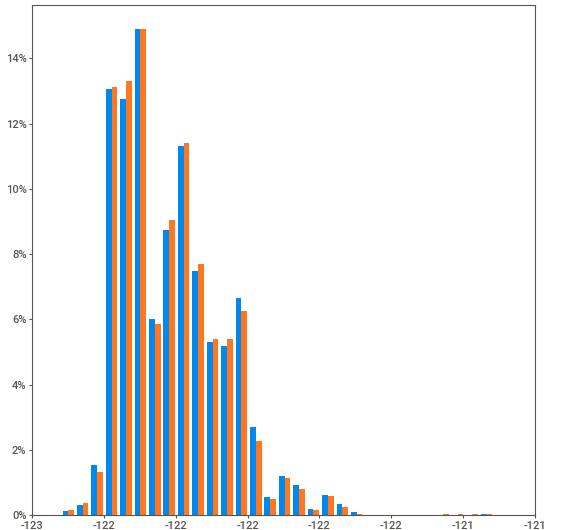
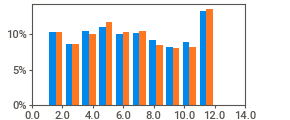
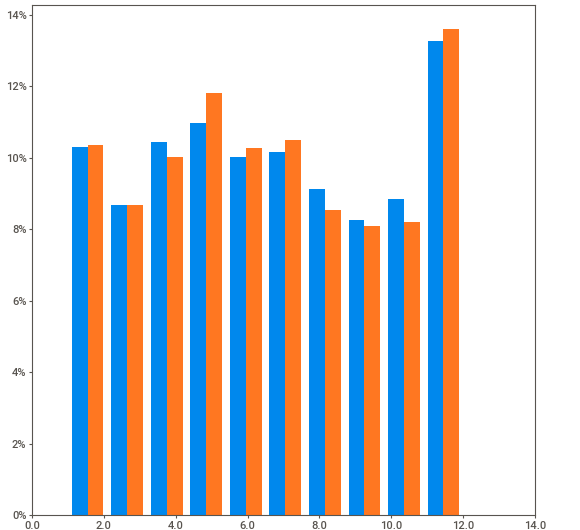
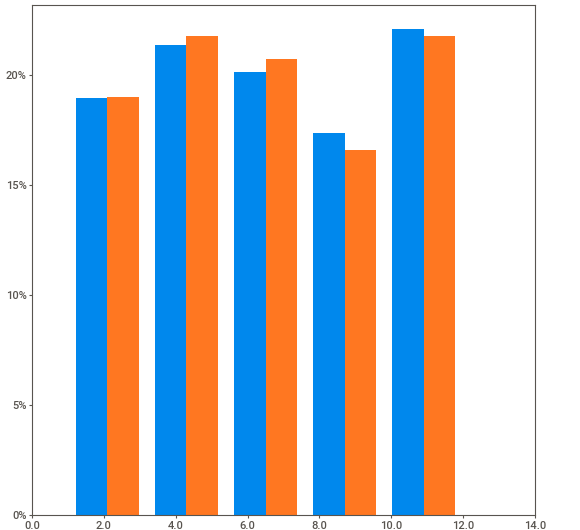
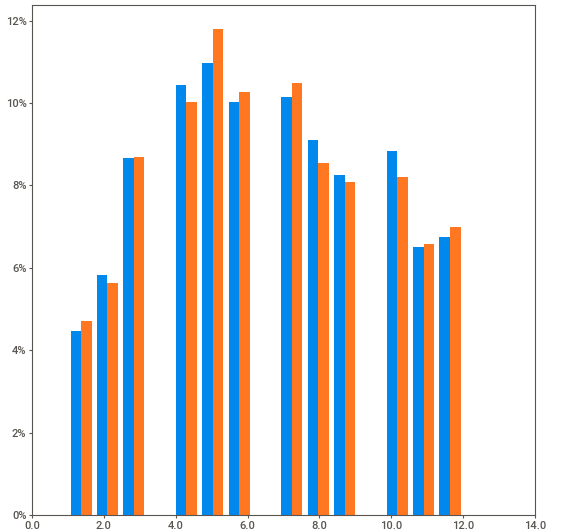
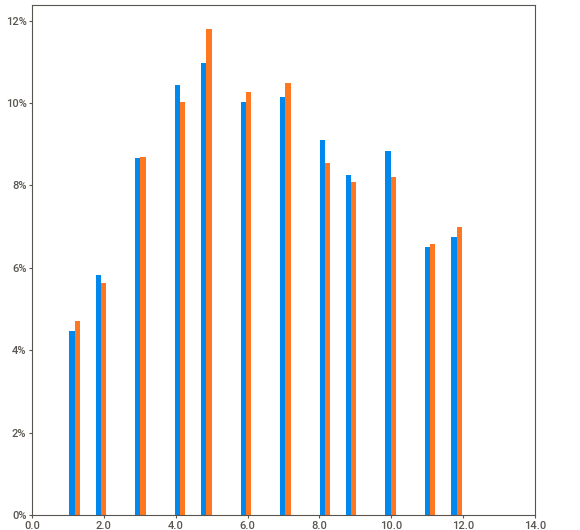
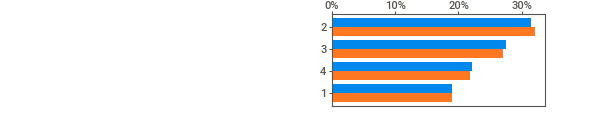
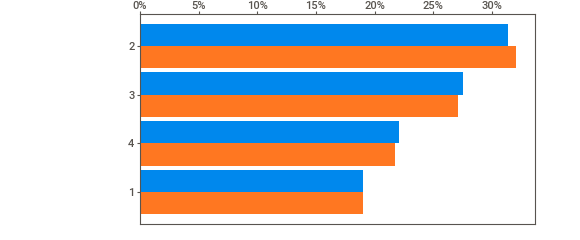
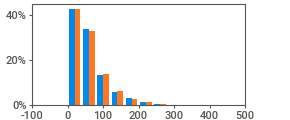
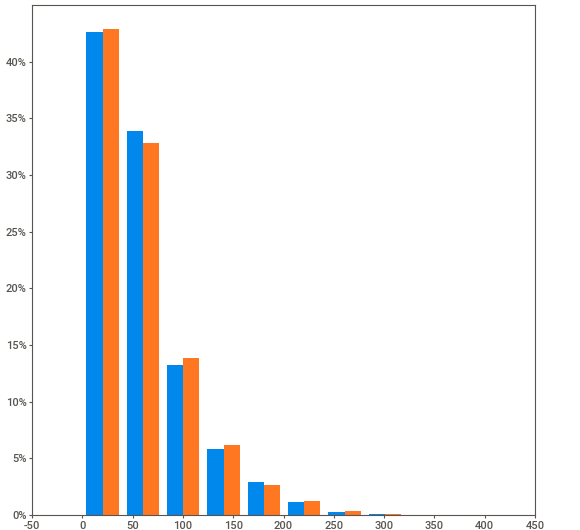
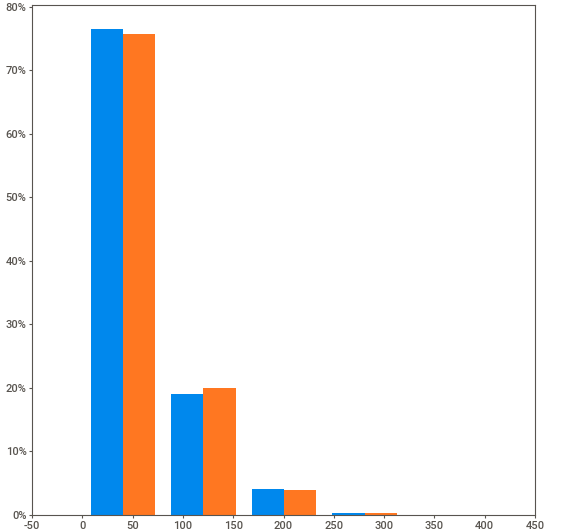
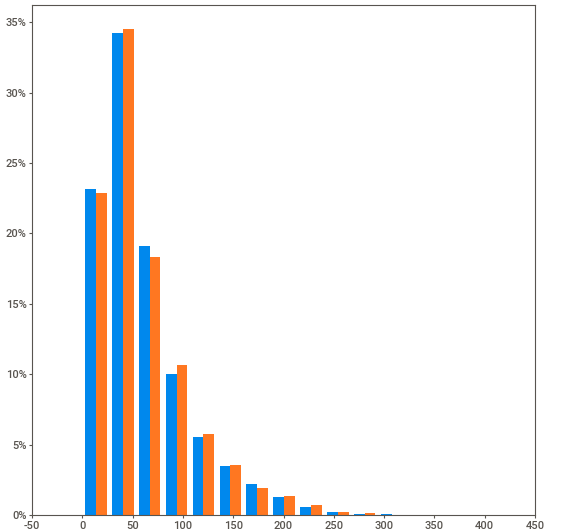
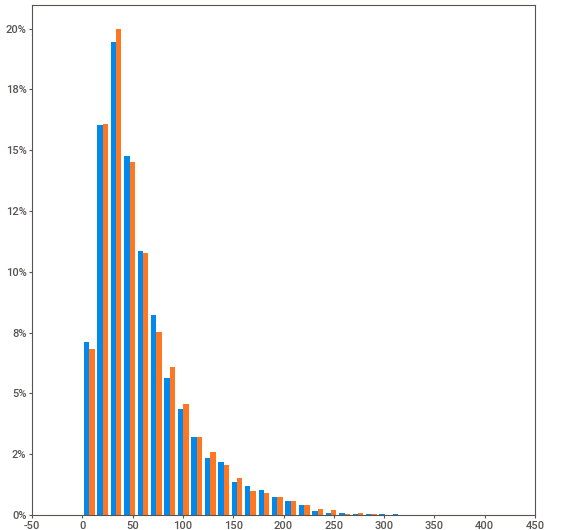
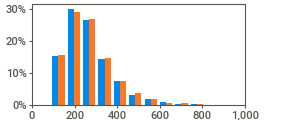
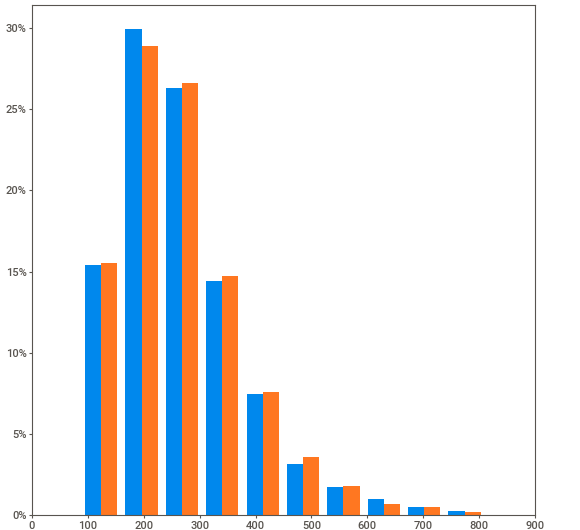
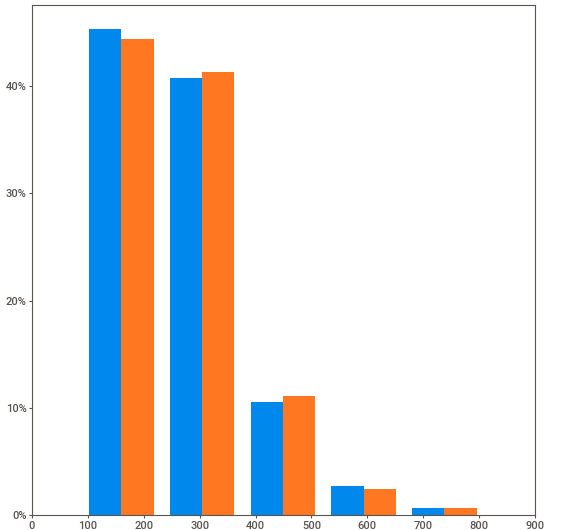
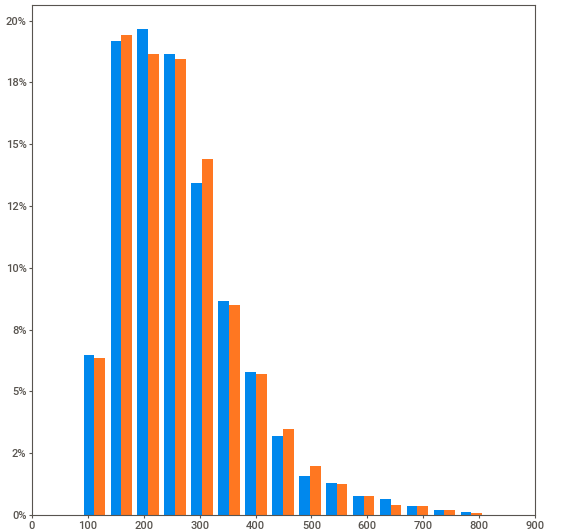
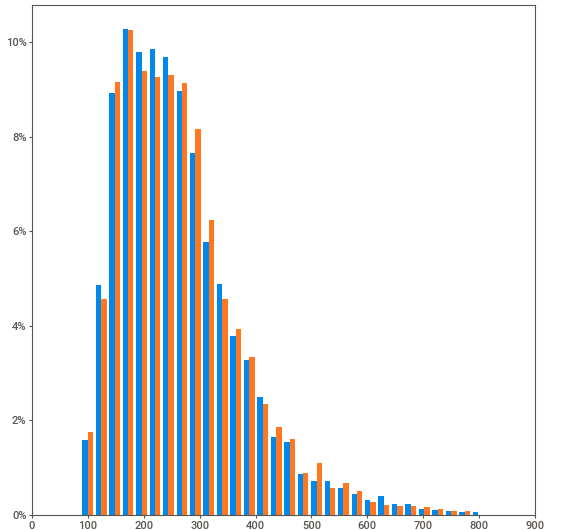
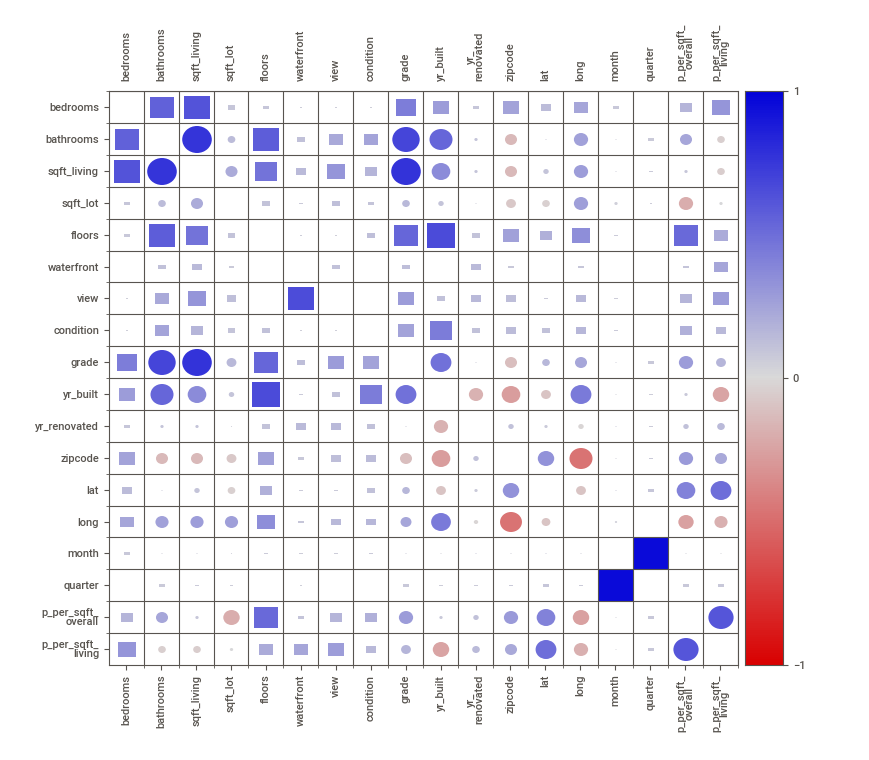
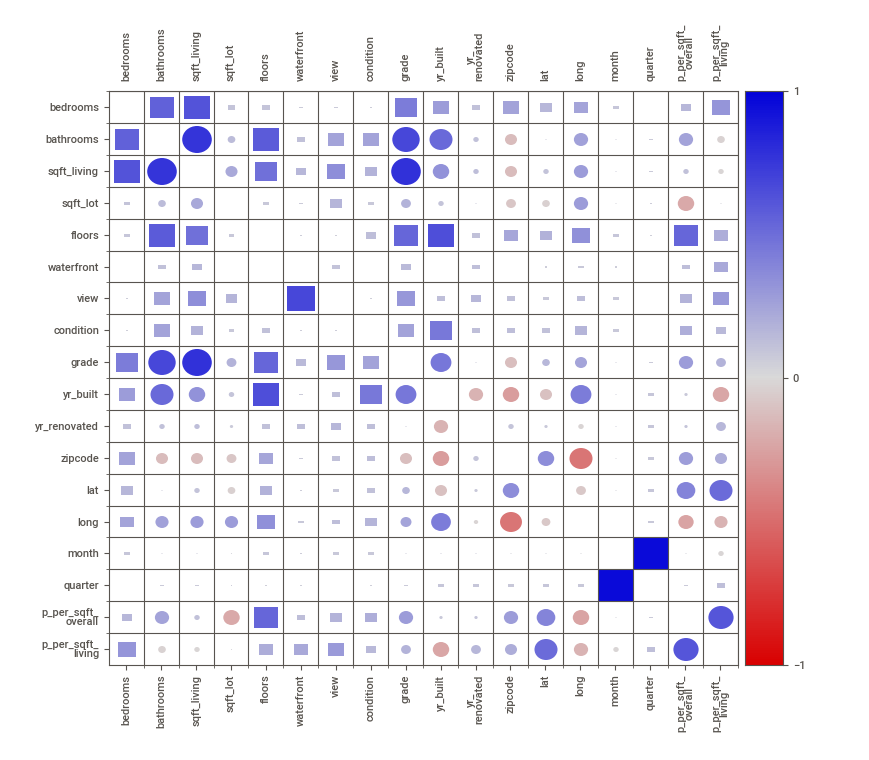

In [162]:
# Comparing Training and Testind data sets in sweetviz report

report_comp=sv.compare([X_train, "Train"], [X_test, "Test"])
# Once the report is recorded there is no necessity in this line 
# report_comp.show_html('Reports/comparison_report.html')
report_comp.show_notebook(w=1000,h=800, layout="widescreen")

In [357]:
# Create a StandardScaler instance

scaler = StandardScaler()
scaler1 = StandardScaler()

# Fit the scaler to the features training dataset
X_scaler = scaler.fit(X_train)  #scaler.fit_transform(X_train)
# y_scaler = scaler1.fit(y_train.values.reshape(-1,1))

# Fit the scaler to the features training dataset
X_train_scaled =X_scaler.transform(X_train)
X_test_scaled =X_scaler.transform(X_test)

# y_train_scaled =y_scaler.transform(y_train.values.reshape(-1,1))
# y_test_scaled =y_scaler.transform(y_test.values.reshape(-1,1))

## Linear regression

In [359]:
# Building Linear Regression model on the modified data set 
# Initiate model instance , fit the model and preict

model_lr = LinearRegression()
# Fit the model using training data
model_lr.fit(X_train_scaled,y_train)
# Make a prediction using the testing data
y_pred_test=model_lr.predict(X_test_scaled)



In [361]:
# Checking the accuracy

print(f"The new training score for Linear regression is {model_lr.score(X_train_scaled, y_train)}")
print(f"The new testing score for Linear regression is {model_lr.score(X_test_scaled, y_test)}")

# y_test = y_scaler.inverse_transform(y_test_scaled)
# y_pred_test = y_scaler.inverse_transform(y_pred_test)

# Evaluating model with the r2_score, MAE and MAPE on predicted values
print("-----")

print(f"The R-squared for Linear regression is {r2_score(y_test,y_pred_test)}")
print(f"The Mean absolute error is {mean_absolute_error(y_test,y_pred_test)}")
print(f"The Mean absolute percentage error is {mean_absolute_percentage_error(y_test,y_pred_test)}")

The new training score for Linear regression is 0.8923205219109591
The new testing score for Linear regression is 0.8819048663874403
-----
The R-squared for Linear regression is 0.8819048663874403
The Mean absolute error is 67439.66582415398
The Mean absolute percentage error is 0.15723156993261264


#### The coefficients of Linear Regression model

In [366]:
#reversing the scaler to   # X_scaler.inverse_transform
coef=pd.DataFrame(X_scaler.inverse_transform(model_lr.coef_).flatten(), X.columns.values)
coef.sort_values(by=0,ascending=False)

0
sqft_living         2.370387e+08
p_per_sqft_living   2.315341e+07
yr_renovated        1.532812e+06
p_per_sqft_overall  6.909579e+05
grade               3.236673e+04
view                6.868081e+03
bathrooms           5.052139e+03
condition           2.870580e+03
quarter             1.954231e+03
waterfront          1.936688e+03
bedrooms            5.148005e+02
long               -1.363123e+01
lat                -6.629954e+02
month              -4.258744e+03
floors             -7.792429e+03
yr_built           -1.703074e+05
zipcode            -1.992695e+05
sqft_living15      -8.886933e+06
sqft_lot15         -1.091048e+08
sqft_lot           -1.983177e+08
id                 -1.416310e+13

Note: As we can see the most affecting features are sqft of living space, price per sqft, year of renovation, grade 

### K-Means


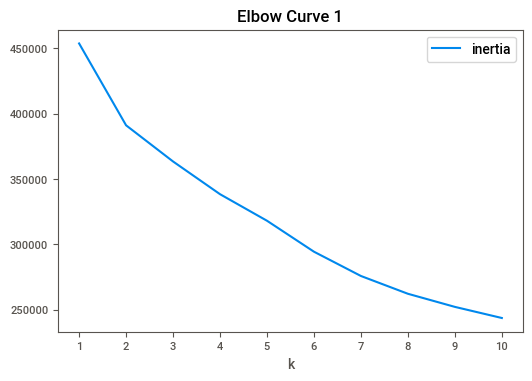

In [409]:
# Use the `StandardScaler()` module from scikit-learn to normalize the data

clustering_df=new_df.drop(["price"],axis=1)
scaled_data = StandardScaler().fit_transform(clustering_df)
# Create a DataFrame with the scaled data
clustering_df_scaled = pd.DataFrame(
    scaled_data,
    columns=clustering_df.columns
)


# Create a list with the number of k-values to try
k=list(range(1,11))
# Create an empy list to store the inertia values
inertia =[]
# Create a for loop to compute the inertia with each possible value of k
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
# 2. Fit the model to the data 
# 3. Append the model.inertia_ to the inertia list

for i in k:
    model_kmeans=KMeans(n_clusters=i,random_state=0)
    model_kmeans.fit(clustering_df_scaled)
    inertia.append(model_kmeans.inertia_)
# Create a dictionary with the data to plot the Elbow curve
elbow_data={
    "k":k,
    "inertia":inertia
}

# Create a DataFrame with the data to plot the Elbow curve
clustering_df_elbow_data=pd.DataFrame(elbow_data)
# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
elbow_chart1 = clustering_df_elbow_data.plot.line(x="k",y="inertia",title="Elbow Curve 1", xticks=k)

In [411]:
# Initialize the K-Means model using the best value for k
model=KMeans(n_clusters=7,random_state=0)
model.fit(clustering_df_scaled)

# Predict the clusters to group the cryptocurrencies using the scaled data
scaled_predicted_data=model.predict(clustering_df_scaled)

# View the resulting array of cluster values.
scaled_predicted_data
# Create a copy of the DataFrame
clustering_df_predicted_data=clustering_df_scaled.copy()
clustering_df_predicted_data["prediction"]=scaled_predicted_data

In [369]:
# Create a scatter plot using hvPlot by setting 
# scatterplot=clustering_df_predicted_data.plot(kind="scatter",figsize=(5,5),title="Clustering with K-means",x="sqft_living", y="grade",cmap="jet",c="prediction")
# scatterplot

In [189]:
# sorted(list(zip(rf.feature_importances_,df.iloc[:,:-1].columns)))

In [413]:
pca = PCA(n_components=4)
# Use the PCA model with `fit_transform` to reduce to    
# three principal components.
pca_scaled=pca.fit_transform(clustering_df_scaled)
# View the first five rows of the DataFrame. 

In [414]:
# Retrieve the explained variance to determine how much information 
# can be attributed to each principal component.
pca.explained_variance_ratio_

array([0.21116818, 0.13007393, 0.09379184, 0.0900925 ])

In [416]:
print(f"KMeans:The explained vriance ratio of principal components is {sum(pca.explained_variance_ratio_)}")

KMeans:The explained vriance ratio of principal components is 0.5251264439983705


In [417]:
# Create a new DataFrame with the PCA data.

# Creating a DataFrame with the PCA data
pca_data_df=pd.DataFrame(pca_scaled,columns=["PCA1","PCA2","PCA3","PCA4"])
# Create a list with the number of k-values to try
# Use a range from 1 to 11
k=list(range(1,11))

# Create an empy list to store the inertia values
inertia=[]

for i in k:
    model=KMeans(n_clusters=i,random_state=0)
    model.fit(pca_data_df)
    inertia.append(model.inertia_)
inertia

# Create a dictionary with the data to plot the Elbow curve
elbow_data={
    "k" : k,
    "inertia" : inertia
}
# Create a DataFrame with the data to plot the Elbow curve
df_elbow_data=pd.DataFrame(elbow_data)
elbow_chart2=df_elbow_data.hvplot(width=600,height=300,x="k",y="inertia",title="Elbow Curve using the PCA", xticks=k)
elbow_chart2

:Curve   [k]   (inertia)

In [418]:
# Initialize the K-Means model using the best value for k
model=KMeans(n_clusters=6,random_state=0)
# Fit the K-Means model using the PCA data
model.fit(pca_data_df)
# Predict the clusters to group the cryptocurrencies using the PCA data
house_clusters=model.predict(pca_data_df)

# Create a copy of the DataFrame with the PCA data
pca_predicted_data_df=pca_data_df.copy()
# Add a new column to the DataFrame with the predicted clusters
pca_predicted_data_df["predicted"]=house_clusters
# Display sample data
pca_predicted_data_df
scatterplot_2=pca_predicted_data_df.hvplot.scatter(x="PCA1",y="PCA2",color= "predicted",cmap="jet",title="Scatter plot for PCA=3")
scatterplot_2

:Scatter   [PCA1]   (PCA2,predicted)

In [419]:
df_clustered=pd.concat([new_df,pca_predicted_data_df["predicted"]],axis=1)

In [420]:

# Separate the y variable, the labels for new Data Frame with cluster prediction column
y=df_clustered["price"]
# Separate the X variable, the features
X=df_clustered.drop(["price"],axis=1)


# GradientBoost

In [421]:
#Since the initial accuracy table showed that Gradient Boost Regressor's accuracy on the testing set is higher we will use it with the new data feautures 

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=101)

In [422]:
# Initiate model instance , fit the model and preict
grboost=GradientBoostingRegressor(random_state=1)
# Fit the model using training data
grboost.fit(X_train,y_train)
# Make a prediction using the testing data
y_pred_test=grboost.predict(X_test)

In [423]:
print(f" The training accuracy for Gradient Boost Regressor model with new feature is {grboost.score(X_train, y_train)}")
print(f" The testing accuracy for Gradient Boost Regressor model with new feature is {grboost.score(X_test, y_test)}")

print("-------")
print(f"The R-squared for Gradient Boost Regression with new feature is {r2_score(y_test,y_pred_test)}")
print(f"The Mean absolute error for Gradient Boost Regression with new feature is {mean_absolute_error(y_test,y_pred_test)}")
print(f"The Mean absolute percentage error for Gradient Boost Regression with new feature is {mean_absolute_percentage_error(y_test,y_pred_test)}")

 The training accuracy for Gradient Boost Regressor model with new feature is 0.9964601211502699
 The testing accuracy for Gradient Boost Regressor model with new feature is 0.99416325205513
-------
The R-squared for Gradient Boost Regression with new feature is 0.99416325205513
The Mean absolute error for Gradient Boost Regression with new feature is 15976.728932754206
The Mean absolute percentage error for Gradient Boost Regression with new feature is 0.031503339984913795


In [424]:
importance_grboost = grboost.feature_importances_
importance_grboost = pd.DataFrame(importance_grboost, index=X.columns, columns=['Importance'])


In [425]:
importance_grboost.sort_values(by=['Importance'], ascending=False)

Importance
sqft_living         4.411042e-01
p_per_sqft_living   3.933606e-01
grade               1.314030e-01
lat                 1.843435e-02
p_per_sqft_overall  1.462564e-02
sqft_lot            3.733752e-04
bathrooms           2.460920e-04
view                1.192450e-04
sqft_lot15          1.134713e-04
sqft_living15       7.732218e-05
yr_built            4.142035e-05
predicted           4.111672e-05
waterfront          3.544998e-05
month               7.849480e-06
condition           5.314266e-06
id                  4.914153e-06
zipcode             3.164179e-06
long                2.895768e-06
yr_renovated        6.583659e-07
quarter             0.000000e+00
bedrooms            0.000000e+00
floors              0.000000e+00

### Checking the accuracy based on new features

In [426]:
#Defining various models

#1. Linear Regressor model
lr_new=LinearRegression()

#2. Decision Tree Regressor
dt_new=DecisionTreeRegressor(random_state=1,criterion='mse',max_depth=10)

#3.Random Forest Regressor
rf_new=RandomForestRegressor(random_state=1,n_estimators=100,max_depth=10)

#4. KNN
knn_new=KNeighborsRegressor(n_neighbors=10)

#5.Boosting
grboost_new=GradientBoostingRegressor(random_state=1)

In [427]:
# Create a function that returns train and test accuracy of different models.

def accuracy_new(model):
    model.fit(X_train,y_train)
    train_accuracy = model.score(X_train, y_train)
    train_accuracy = np.round(train_accuracy*100, 2)
    test_accuracy = model.score(X_test, y_test)
    test_accuracy = np.round(test_accuracy*100, 2)
    return train_accuracy,test_accuracy

In [428]:
# Create DataFrame that illustrates the accuracy of tmodels
accuracy_new_df=pd.DataFrame([accuracy_new(lr_new), accuracy_new(dt_new), accuracy_new(rf_new), 
                                           accuracy_new(knn_new), accuracy_new(grboost_new)])
accuracy_new_df.index = ['LinearReg', 'DecisionTree','RandomForest','KNN','GradienBoost']
accuracy_new_df.columns=['Train_accuracy(%)','Test_accuracy(%)']
sorted_accuracy_new_df = accuracy_new_df.sort_values(by = 'Train_accuracy(%)', ascending = False)
sorted_accuracy_new_df

Train_accuracy(%)  Test_accuracy(%)
RandomForest              99.87             99.26
DecisionTree              99.71             98.21
GradienBoost              99.65             99.42
LinearReg                 89.34             88.74
KNN                       43.92             27.35

<AxesSubplot:title={'center':'New accuracy scores for 5 different ML models'}>

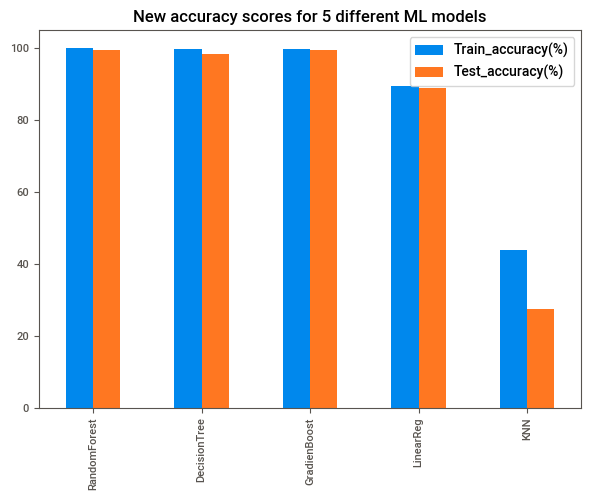

In [429]:
sorted_accuracy_new_df.plot(legend=True,kind="bar",title="New accuracy scores for 5 different ML models", figsize=(7,5))

### Conclusion: As we can see our accuracy score increased dramatically for all models. The 2 of them - Random Forests(99.25% accuracy on testing data) and Gradien Boost Regressor(99.41% accuracy on testing data) performed specifically well. 